In [ ]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Tian Jun(tianjun.cpp@gmail.com)                                #
# 2016 Artem Oboturov(oboturov@gmail.com)                             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

class Bandit:
    # @kArm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @stepSize: constant step size for updating estimations
    # @sampleAverages: if True, use sample averages to update estimations instead of constant step size
    # @UCB: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradientBaseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, kArm=10, epsilon=0., initial=0., stepSize=0.1, sampleAverages=False, UCBParam=None,
                 gradient=False, gradientBaseline=False, trueReward=0.):
        self.k = kArm
        self.stepSize = stepSize
        self.sampleAverages = sampleAverages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCBParam = UCBParam
        self.gradient = gradient
        self.gradientBaseline = gradientBaseline
        self.averageReward = 0
        self.trueReward = trueReward

        # real reward for each action
        self.qTrue = []

        # estimation for each action
        self.qEst = np.zeros(self.k)

        # # of chosen times for each action
        self.actionCount = []

        self.epsilon = epsilon

        # initialize real rewards with N(0,1) distribution and estimations with desired initial value
        for i in range(0, self.k):
            self.qTrue.append(np.random.randn() + trueReward)
            self.qEst[i] = initial
            self.actionCount.append(0)

        self.bestAction = np.argmax(self.qTrue)

    # get an action for this bandit, explore or exploit?
    def getAction(self):
        # explore
        if self.epsilon > 0:
            if np.random.binomial(1, self.epsilon) == 1:
                np.random.shuffle(self.indices)
                return self.indices[0]

        # exploit
        if self.UCBParam is not None:
            UCBEst = self.qEst + \
                     self.UCBParam * np.sqrt(np.log(self.time + 1) / (np.asarray(self.actionCount) + 1))
            return np.argmax(UCBEst)
        if self.gradient:
            expEst = np.exp(self.qEst)
            self.actionProb = expEst / np.sum(expEst)
            return np.random.choice(self.indices, p=self.actionProb)
        return np.argmax(self.qEst)

    # take an action, update estimation for this action
    def takeAction(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.qTrue[action]
        print(reward)
#         d1.append(reward)
#         d2.append(self.qTrue[action]+np.random.normal(loc=0, scale=1, size=1))
        
        self.time += 1
        self.averageReward = (self.time - 1.0) / self.time * self.averageReward + reward / self.time
        self.actionCount[action] += 1

        if self.sampleAverages:
            # update estimation using sample averages
#             print(self.qEst[action] + (reward - self.qEst[action])/self.actionCount[action])
            self.qEst[action] += 1.0 / self.actionCount[action] * (reward - self.qEst[action])
#             print(self.qEst[action])
        elif self.gradient:
            oneHot = np.zeros(self.k)
            oneHot[action] = 1
            if self.gradientBaseline:
                baseline = self.averageReward
            else:
                baseline = 0
            self.qEst = self.qEst + self.stepSize * (reward - baseline) * (oneHot - self.actionProb)
        else:
            # update estimation with constant step size
            self.qEst[action] += self.stepSize * (reward - self.qEst[action])
        return reward

figureIndex = 0

# for figure 2.1
def figure2_1():
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    sns.violinplot(data=np.random.randn(200,10) + np.random.randn(10))
    plt.xlabel("Action")
    plt.ylabel("Reward distribution")

def banditSimulation(nBandits, time, bandits):
    bestActionCounts = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
    averageRewards = [np.zeros(time, dtype='float') for _ in range(0, len(bandits))]
#     print(averageRewards)
    for banditInd, bandit in enumerate(bandits):
        for i in range(0, nBandits):
            for t in range(0, time):
                action = bandit[i].getAction()
                reward = bandit[i].takeAction(action)
                averageRewards[banditInd][t] += reward
#                 print(averageRewards[banditInd])
                if action == bandit[i].bestAction:
                    bestActionCounts[banditInd][t] += 1
        bestActionCounts[banditInd] /= nBandits
        print(nBandits)
        print(averageRewards[banditInd])
        averageRewards[banditInd] /= nBandits
        print(averageRewards[banditInd])
    return bestActionCounts, averageRewards


# for figure 2.2
def epsilonGreedy(nBandits, time):
    epsilons = [0, 0.1, 0.01]
    bandits = []
    k = 0
    for epsInd, eps in enumerate(epsilons):
        bandits.append([Bandit(epsilon=eps, sampleAverages=True) for _ in range(0, nBandits)])
        for i in range(0, nBandits):
            print(bandits[k][i].qTrue)
        k += 1
    bestActionCounts, averageRewards = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, counts in zip(epsilons, bestActionCounts):
        plt.plot(counts, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()
    plt.figure(figureIndex)
    figureIndex += 1
    for eps, rewards in zip(epsilons, averageRewards):
        plt.plot(rewards, label='epsilon = '+str(eps))
    plt.xlabel('Steps')
    plt.ylabel('average reward')
    plt.legend()
    return averageRewards


# for figure 2.3
def optimisticInitialValues(nBandits, time):
    bandits = [[], []]
    bandits[0] = [Bandit(epsilon=0, initial=5, stepSize=0.1) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(epsilon=0.1, initial=0, stepSize=0.1) for _ in range(0, nBandits)]
    bestActionCounts, _ = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(bestActionCounts[0], label='epsilon = 0, q = 5')
    plt.plot(bestActionCounts[1], label='epsilon = 0.1, q = 0')
    plt.xlabel('Steps')
    plt.ylabel('% optimal action')
    plt.legend()


# for figure 2.4
def ucb(nBandits, time):
    bandits = [[], []]
    bandits[0] = [Bandit(epsilon=0, stepSize=0.1, UCBParam=2) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(epsilon=0.1, stepSize=0.1) for _ in range(0, nBandits)]
    _, averageRewards = banditSimulation(nBandits, time, bandits)
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    plt.plot(averageRewards[0], label='UCB c = 2')
    plt.plot(averageRewards[1], label='epsilon greedy epsilon = 0.1')
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()


# for figure 2.5
def gradientBandit(nBandits, time):
    bandits =[[], [], [], []]
    bandits[0] = [Bandit(gradient=True, stepSize=0.1, gradientBaseline=True, trueReward=4) for _ in range(0, nBandits)]
    bandits[1] = [Bandit(gradient=True, stepSize=0.1, gradientBaseline=False, trueReward=4) for _ in range(0, nBandits)]
    bandits[2] = [Bandit(gradient=True, stepSize=0.4, gradientBaseline=True, trueReward=4) for _ in range(0, nBandits)]
    bandits[3] = [Bandit(gradient=True, stepSize=0.4, gradientBaseline=False, trueReward=4) for _ in range(0, nBandits)]
    bestActionCounts, _ = banditSimulation(nBandits, time, bandits)
    labels = ['alpha = 0.1, with baseline',
              'alpha = 0.1, without baseline',
              'alpha = 0.4, with baseline',
              'alpha = 0.4, without baseline']
    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    for i in range(0, len(bandits)):
        plt.plot(bestActionCounts[i], label=labels[i])
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.legend()

# Figure 2.6
def figure2_6(nBandits, time):
    labels = ['epsilon-greedy', 'gradient bandit',
              'UCB', 'optimistic initialization']
    generators = [lambda epsilon: Bandit(epsilon=epsilon, sampleAverages=True),
                  lambda alpha: Bandit(gradient=True, stepSize=alpha, gradientBaseline=True),
                  lambda coef: Bandit(epsilon=0, stepSize=0.1, UCBParam=coef),
                  lambda initial: Bandit(epsilon=0, initial=initial, stepSize=0.1)]
    parameters = [np.arange(-7, -1),
                  np.arange(-5, 2),
                  np.arange(-4, 3),
                  np.arange(-2, 3)]

    bandits = [[generator(pow(2, param)) for _ in range(0, nBandits)] for generator, parameter in zip(generators, parameters) for param in parameter]
    _, averageRewards = banditSimulation(nBandits, time, bandits)
    rewards = np.sum(averageRewards, axis=1)/time

    global figureIndex
    plt.figure(figureIndex)
    figureIndex += 1
    i = 0
    for label, parameter in zip(labels, parameters):
        l = len(parameter)
        plt.plot(parameter, rewards[i:i+l], label=label)
        i += l
    plt.xlabel('Parameter(2^x)')
    plt.ylabel('Average reward')
    plt.legend()


figure2_1()
avgReward = epsilonGreedy(2000, 1000)
plt.show()


# optimisticInitialValues(2000, 1000)
# ucb(2000, 1000)
# gradientBandit(2000, 1000)

# This will take somehow a long time
# figure2_6(2000, 1000)

# plt.show()

[0.20736991895511203, 0.8899522145998543, 0.34074245203518294, -1.4014173961245426, 0.3274927542831813, -1.7467045294894046, -0.495792730181932, 1.8175222566466316, -0.29883852806874617, 0.0025779368296332305]
[0.8823910401530937, 0.9994733431637975, 0.8609822672301054, -0.13588576633299007, 1.4321601961898422, -0.3921002353307928, -1.5095486998780492, 0.9604817274185609, 0.16208391176904233, 0.11026944104802794]
[-0.7286507769409888, 0.4928204464770169, 1.1054498248788103, 0.467891766457992, 0.41834953154736837, 0.46008541123398167, -0.19200631319865447, -0.7304854813016145, -0.35239306655761193, 1.1232591786968182]
[1.1577266020206223, -1.2182973120427545, 0.7572169958205195, 0.2171557052987917, -0.18803761278099818, 0.20468412074503842, -0.7120908104208709, -0.16497479677720733, -0.31699699035162265, -0.9524784224131724]
[0.010462062823336987, -0.36312464839870034, -2.221583296523744, -1.0119789721213472, -0.03141726350707112, 1.7629754384671488, -0.5134252111693023, -1.118810412271

[0.979555579127569, 0.5470713175958979, -0.7636823517435413, -1.3097386888988085, -1.3530568517291066, -0.8559762985846059, 0.3143267715686739, 1.3618748513280323, -0.16515249759962553, 0.6046948408621582]
[0.7756594665933415, 0.7089481607141133, -1.0305430552653394, 0.8695634845487022, -1.0020026066067165, -1.764338889760396, 2.3422507773451477, 1.3608353407629235, -0.9782467318491805, -1.7070340965541486]
[0.15070541014794506, -1.1594358637010858, -0.39997927373936815, -1.0778159714664806, -0.48013110170723355, -0.6096864672364849, 1.2813204965480312, 1.2254683750848627, 0.026413589801296527, 0.31183652331102113]
[-0.32427439171719985, 0.5263327285065361, 1.371189511779394, -0.673933386394378, -1.8896700468749803, 0.20394720457744253, 0.6833533825285204, 0.6924327021767184, 0.07684810502695798, 0.7783278542523777]
[-0.31015119711541567, -0.5122318571885717, 1.7065302389059196, -0.6079399672783531, 1.207645553268937, -0.7738187031134401, -0.40961109699797, -0.6546448205912203, 2.28836

[0.4723947469127557, -0.15533506335327799, 0.7087180468939223, -0.3726848140768544, 0.9248180319927567, -0.8374262573444504, 0.11232507551137927, 0.2762352316566366, 0.4070097487581715, -0.5806076798752889]
[0.4743632354612852, 0.2536730280597799, -1.71000042797136, 1.9486146058607194, -1.0056361688042825, 0.6479976789316476, -0.8226590737352044, 0.29146215169388084, 1.8166178728259421, -0.18740368946271363]
[1.9757007211017736, -0.5812221975289346, -1.3171465104024713, 0.15249064293746228, -1.380421825005754, 0.6112330471064459, 0.32649065066191196, 1.8734192399441947, 0.3875906389781994, -1.4390011352176149]
[-1.4429583447474161, 0.2963282656408482, 0.9357437044006676, 0.5239445992426348, 0.08817896404182436, 0.27527333292428946, -0.4357553440630347, -2.4926796681759193, 0.10340140614062082, -1.7972635872497364]
[-0.9060649060873288, 0.5015539927231747, 0.4764529764158387, -2.197540551532227, -0.34945420168447366, -0.36874219837117506, -2.0767695784650573, -0.3605981788733542, 0.8009

[0.20321933408313206, 1.347505185914013, 0.5747494139078444, -0.16204615305856046, 0.9497955935581683, 0.35760668409922675, 0.9437230558462639, -1.360893348963906, 1.2257284659279355, 2.0286361747770405]
[0.9190224162507933, -0.9761309465849239, -2.1501302798885633, 0.5088722023628788, 1.8708894003871452, -0.24148144069734956, -0.3188066142685031, 1.1435057543232297, 0.7704977106823432, -1.3417893472218645]
[0.07433810724143605, -0.05091361796910576, 0.12778375882721885, 1.119213786294826, -0.8461017941763654, 0.6391553435488, -0.9613998341329102, -0.713667591116139, 1.5104061196291558, -1.7030407146214397]
[0.3820981631449978, -0.10201534396050116, -0.9047308827883153, -0.6729210775812628, 1.3765059348168325, 0.8254327211374364, -1.5462608540723435, 0.2402254093380482, 0.149284134316146, -0.013905798227398519]
[1.4578001700813985, -0.45814324930564954, 0.16471705138236423, 0.17967026443281425, -0.7820287680097573, 0.142599857752658, -1.8431170660416747, 1.4785623052961188, 0.544597090

[2.2705644704225447, 0.0023755779765183213, -0.6488422467702305, -0.39197404366054667, -1.0727162664904184, -0.05995292576913445, -0.5122667412296618, -0.07037958545628785, 1.0690797190874792, -0.28443233754498587]
[0.8657697580272152, 0.6679103978027551, -1.4785426899836953, 0.73728829513787, 0.6740659179272156, -0.6496448342284814, 0.7153831195109936, 0.14347733493899634, -0.34215268359066425, 0.7161317918118426]
[0.7645860354145052, 0.45467042571233734, -0.7353569641769486, 1.1924450676478324, -0.7408357803433658, -0.48239760551511385, 0.6733982804540406, 0.33167907939614977, -0.8958414747145663, 0.48500934952698227]
[-1.1191379697661128, -2.52321257403501, -0.19764175396058, 0.4411266510849154, 0.5167267439774778, -0.0004635366306951626, 0.6391308970741906, -0.7085527941098219, -1.354736867379808, -0.6518293886692578]
[1.3696533383422602, 1.3549356480930175, -0.1907303678439128, -0.939354283648995, -0.6026683969734784, -0.5553902493699456, -0.6471748579777232, 0.7305035266489359, -

[0.6266532463293971, -0.5736397645346659, 0.9159917058369739, 0.31373532600895354, 0.14419973824906723, -0.31344374898219185, 0.34923998534477513, 0.6850743187058779, -0.3398580493204404, -0.5927468265966842]
[-1.1541489610433193, 0.49391383100233777, -1.2868261740975984, 0.9403695168905225, -0.3155364404140428, 0.3210648849902151, -0.5532145025005363, 0.21656318451219372, 1.2976917217084303, 0.9005017870432759]
[-2.3058825232854154, 0.10617196674314028, 1.6207684581934596, 0.7709208142195141, 0.8465167645270071, 1.2627461486394675, -1.0492587559749076, 1.3286912563917428, 0.5786391106192805, 0.6447783143220797]
[0.5727422152491113, -1.405385556281866, -1.0605385896178428, 0.22104979829999533, -1.0810435970205123, 2.46330225935479, 0.890393846933003, 0.0032304278885704873, 0.9212862496866401, 1.4418941531224827]
[-1.6448347229801024, 0.062092626667772, 0.7530505320628003, -0.5800517959083333, -1.0897709408353666, 0.10520661819289946, 0.18561024340384835, 0.9947833127208237, -1.92473300

-0.8198212326296426
-0.24039403118017472
1.1636297652891183
1.5744577391507637
-1.0437063104066393
0.393817937389436
-0.9872693887262656
-1.5819822434203086
-0.4466972079476506
1.1203241560322048
-0.18672855445969921
1.0509803553649189
0.2303074602043661
2.295874325121356
-0.2912832782000789
0.021731950475132156
-0.8438222526415218
1.1522358271002286
2.0336238866994933
-1.390319210219884
0.501856795675411
1.2709045805020431
1.5158385976301056
0.025193579965991197
1.0978942198651296
-0.7680394557593799
0.12698514530153626
1.5984395764509682
2.5088725761954924
1.5552429308152282
-0.5905516719516679
0.5761475933763168
-0.32073726963983257
-0.5418721903196917
-0.9204219384326644
1.5964480049239331
0.4504462235113686
-0.3211955480976297
-1.6090178902605856
1.523066501680231
-1.411509319356665
1.0232673681754343
-0.3946331508035283
1.1838028248924004
1.1271840022207904
0.21906686400500305
-0.011411127321120262
0.13046307839871082
0.5430040806610478
-0.21741452797614375
1.033211961741275
0.34

0.7264313879427219
3.5646835643001653
0.4315001052983856
0.09074784318661677
-0.35750488196291824
0.05269397728844738
0.17127600071938276
1.9046371367091872
1.2933359190816358
-0.6420885053420611
0.4050745543416274
1.2771363255418502
0.6970326375882898
0.2711102884513894
-0.08482336662617046
1.2400833860715623
0.6116712763011045
0.9715212105120958
1.1174405331011856
0.4153552395068405
-0.1007750114458667
-0.24841985226907365
-1.9172382253096132
0.3247485334870432
1.7468433614535452
0.6912094900657816
-0.33034976662985743
-0.36034904342906654
0.40169083735650274
0.1748681607167592
-0.019109066038832723
1.1537538608431614
-0.31451680516725805
1.4480335638281778
-0.717544703088723
-1.134809738210751
-0.17084258983927497
-0.012104596390138223
1.031693205885926
-0.8291254738356053
-0.9889925055253013
1.3205165532607817
0.7915952812311123
-0.41904991556173415
1.9683348557280422
-0.21654323737463527
-1.2798681879442373
2.467907375603747
1.1683298238224362
0.4640122171315281
-0.554679240845788

0.3394300880049479
0.7284121991948969
3.359205099286486
2.339320359997065
2.155657778298376
2.2615017813171607
2.147080615487636
2.255086171651644
0.05665669354986158
3.86785137782612
1.6747793265008812
1.326063509008672
0.07203076435776756
0.2630044986180047
2.2024220470126017
4.128284081200851
0.7531007718040827
3.427833283561898
1.0877617797405958
3.205924972586255
1.815287303192298
2.154644745005259
1.8772538232779474
2.870161862666788
2.413524748212746
1.7383260944467198
1.6625872545784026
1.5756693811587705
1.6969481566349662
0.21497993481115718
2.30856657314359
1.678547272668256
1.8855371435619308
2.4041362163159152
2.275366351898593
1.862028019270707
2.409987450134645
3.2694592704249716
2.5742711417846755
1.8658602396121742
1.2034029467385856
2.138659451353936
-0.11083075937290765
2.3536081502651918
-1.7039310270379144
2.900937467948621
2.5757478953447537
1.6849312667078493
2.540208192706837
1.0765296198495908
2.2607371300344323
2.1828961804333122
2.8400462044312107
2.876841945

-0.5248779014679895
0.36883853514235787
-0.920332152565172
0.6546479879655742
-1.6416959008589416
0.1051917074975384
0.5038003861435203
0.001760148326893085
-0.7969884357949693
-0.614088217562592
0.41717174605890506
-0.9750698906530497
-0.39553342970127947
0.8240614114809849
1.1351025384236126
1.4798309513080001
1.7332403635247058
0.36911571805020443
-0.3870556623282644
0.38173896451018396
-0.08536741637203282
-0.014067867704301629
0.23913984292104973
0.2380846198270686
1.9986483756083637
1.7077693185765161
-0.806084938483637
0.6935194244554348
-1.6189275511284915
1.7365273102304972
1.023785333176253
0.7199591067923036
-0.29489557447954673
-0.32609917859136517
-0.47690475930135845
0.36530239769948597
-0.2573815545589625
0.877690343451935
-1.856089290404663
0.9517603682384134
-0.6437560364660331
1.2602887060514973
-0.15473700535971702
-0.8322891413807152
0.2158510090456672
1.4922768634751822
-1.9896818694591054
1.8977683914020713
0.6143270346979149
1.6896789640486003
1.4552481798770167


2.3608679454541575
2.91503088122483
1.3302553651072815
1.9515216797805834
0.9947910279684523
2.5541036576608063
2.4092516472853345
2.1954734365740483
1.5042577968342186
2.3212445551107552
-0.4202599740606152
2.3661186084846744
3.4937485670638937
3.085201757237055
0.31144074622841855
2.7012280499716588
2.5819722856370273
2.7613478832496448
1.8035807653308538
1.0729711608695962
2.1070744584253904
1.8858534868614967
0.7257861740710191
2.9083727592767756
0.6988565406884814
1.2225241581033806
1.485063741331241
2.1561988523646924
0.16253338141303142
1.8132574221853568
1.41134375881415
1.2614556437733406
2.7550960882257316
1.9158218845564636
-0.6216797160929219
0.5035429277715435
2.304070780130118
2.997875680087387
-0.2689077439684704
2.2270043122056515
1.117679122147969
1.993598111175501
2.090438178107871
2.652526465769328
-0.47566478570130877
0.9700962063642784
0.08617500686525603
2.807243513966577
1.541878539939751
1.424163805756539
-0.7668829133299317
1.6887137024776975
-0.367365919441995

-0.3236397130510795
0.6501570438601634
0.8101526660306756
-0.5598430675010306
-0.27262600014401595
1.3131078708009403
-0.6096865098862054
1.460468957136184
2.602292566537006
0.585090418059819
3.4521827493431054
1.3189911516641035
1.457331028915932
1.8231760193245803
1.8164553016831073
1.5794700941362976
0.9371331602428893
2.3963275675006273
0.5097025779919914
1.9569223614017792
1.0570514965891338
2.040480514790697
1.0319180849209335
-0.11642468727918676
0.361271039077397
0.7108473347740868
-0.7823406038099434
0.19123949508287064
0.5772756362608817
0.9525733916273571
1.3402240009244109
0.8823346580359765
-0.19428931640970215
2.2174737085045253
1.8075144427551704
1.0377108479970305
0.9343315383013369
1.6116505592928219
2.528635511123344
2.1022136925674277
0.696006041706857
2.679268217077168
0.33213946536501804
0.37764372102908594
2.1202984337133115
2.9237620239467974
-0.5979462663023187
1.0215908270272127
0.4269219020688748
1.2699648677953412
2.1332266399568285
0.4092462478822303
1.56112

2.1800847762354736
1.4410416614704609
-0.19611958227575654
0.07539437796444537
-0.38311313183289397
1.3400250184516795
0.3675911347186036
0.11330603945794221
-0.5045578556426132
-0.6796569217292717
-2.918620427308356
2.787818282811809
-0.6713880457332125
-0.7859723724935744
0.14571615667851867
0.8548170060445792
0.1446119611984571
0.5722282120096236
2.588625162327299
1.4345289353231312
0.14966677035414294
1.4049573027104687
-0.503572049107056
-0.021693113139984455
-0.4422680746474995
1.2662530744294553
2.8146471467125926
0.19678363087705403
-0.10168182024060335
0.7007419029086819
0.2881772592077796
-1.2727165100907603
1.6854858747635961
1.4398988153794519
0.35453643170407906
-0.916266076675368
1.4256448932652712
-0.21337714341635472
-0.2872939091384604
-0.04932245907805344
0.5618711060869931
1.5990665809792666
1.4629283780151652
2.0614921390018845
-0.09222927209738507
1.2915673819053224
0.22635869595362074
1.9037327535196922
1.1546051609575358
1.9280174150598208
1.5669750964338012
0.44

0.7602530688413547
2.2461122287171116
-1.0827440741012915
0.701526695994743
2.045593121052999
-1.2160393710806656
2.3881694422279054
1.7557453481936562
0.7992584754898018
0.36395389254926314
0.4580726038882956
-0.2794431106709254
1.271507298413038
0.7070727818721317
1.5996774638770401
-2.0689689539797893
0.5483227049806065
0.22859124917346885
0.22332541117646065
-0.5601043111085826
0.07558739539809622
-0.22690256966371236
0.19242660571655423
0.4769711938416036
0.8794249736721355
1.0660088944202277
0.8320520803250484
0.7525709253545234
0.6345709644754908
1.5852877243624623
0.44983485731342043
2.576182470177976
0.7229633929245377
-0.03263741612946092
0.07834535107533169
0.958442885244957
0.5820818350047676
1.127963054214388
-0.4274454047296208
1.1953664641149402
-0.32155106537656153
0.5702957418191785
0.3171432512583901
2.0324473467656285
1.6797320734487804
0.5459365377002021
-1.4694563980980317
-0.07175225222200665
0.8425551973883573
1.4311982045462854
1.1092369998743798
-0.195450710334

0.4389969126103519
1.9554309215897248
-0.21608057957387827
2.1181871460158357
1.6638256441530763
2.7504291207231795
0.666480502332703
1.3663049542090415
0.7102340335452166
2.908513680471618
3.7192714889540475
1.1848083653507853
-2.7220918344824048
-0.9707063746970572
0.12014891278851837
-1.76014276521447
0.47447886540100115
-0.4303936372736802
0.4212050055724925
-1.2167135386252972
2.3707286107164
2.9103211690619144
0.9069660479715771
0.6911505067278315
-0.6431931155824435
0.6017884856414895
1.750288980750298
1.9417530718656866
0.6397794706199991
2.2478963131953025
1.476504087169872
0.20813367768736368
0.5611250625340023
0.6149189782607746
1.1069854695690233
2.7394851135230756
2.5624547399506135
1.3729724972122281
0.8085047615444463
1.594912366160926
-0.42134993937382403
1.2915343500470677
0.18850952053589287
1.3393173064698638
2.3831479519770085
0.5981889526041685
0.9386622568781411
2.757470522275689
-0.8655564722198357
2.271234950288755
1.5072710189781975
-0.4146895335109837
1.542767

0.33506567305107987
-0.13821729196340532
0.5909697860866396
-0.3098740331851973
0.16610400563885902
0.6086352620892956
0.0014584244780365685
1.0941709891666946
1.5830643217350293
-0.9035949991899086
0.3126027326740163
1.0682057864076113
0.6049568665242627
0.8441093710555077
0.34175381771853663
1.8799234235663107
0.4036426863901797
1.7997818388353164
-0.5810139458765733
1.8864763877761974
-1.1770640945209643
1.1712476580409652
0.5680155119651786
-0.09747838238834944
-0.107253071318474
0.641938310638816
1.4773918791710565
-0.7002757084004592
-0.3721459655246378
0.7908361849033771
0.10319038561765631
-0.17444099366900362
-0.010310654295609956
0.5806302920085784
0.06086970985698814
1.1367675294461004
1.804323622243546
-2.7448919113988275
0.5688414700702356
1.3067250059373778
-0.9346634863752901
-0.25857536181011803
2.2102883686612578
1.5056736074416288
1.7068940835866058
0.5903297017113556
-1.252803639796793
-0.5650250197339737
-0.0650160677196952
0.06661151513704794
0.9669097069640498
0.0

-0.1432266994003767
1.3531252742860544
-0.6519526816910192
-0.7955695083918847
0.3098452502610607
0.8820765143744468
1.0275558289384061
1.8878037408516444
1.1110810628427925
2.471472885660346
0.9361955355899396
1.051201206153618
0.02555856125764544
-0.2938501203621252
-1.8162844858387008
1.39082117966496
2.661350280790236
-1.453261316277366
0.2978748062940666
0.9198365218928897
0.6356770113743393
1.0777244397783774
0.3130640030460494
-0.9868075707429581
-0.18625363814515306
0.0883986965737229
2.9478810313016544
-0.11705603341623105
1.3146244345714808
1.4505281493467084
-0.7283798160996918
3.3929614347581443
1.1938606589987457
-0.014617853987520135
0.3495914471987629
-1.1047804603244331
0.7842868148119357
1.8099951885712895
1.3148503439068084
1.1228121152657533
0.46603052954043417
1.198406617668296
-0.3957022658993362
0.15291665382563013
1.7005583829285857
1.393772094697705
1.4738900925289036
0.5835100624529953
1.9014344395429013
2.0779918342875865
0.5072441665133078
0.4559551312923563


0.6025780922043849
2.855090116662431
0.0068139557499967696
1.1264469935431585
0.12984037783553493
-0.06049020806902439
0.8016881844443875
1.5331317685930357
-0.33313740956436955
2.0751837205413604
0.6051879974199766
0.06342213243783446
1.3734996576965148
0.07463088390360395
-0.8072846848242078
-0.46420601844012876
-0.5071068778266009
0.8878167049188705
0.1127355347591909
0.417151197500891
0.9391987374161106
0.42603620169302797
-0.010957806354202626
1.2387223312048852
0.5942931128440287
1.0071346459646655
0.8932193691314869
0.6274754705445261
1.5730123733407488
-1.1202336200806275
0.2023158078307083
2.4460428165754258
0.6900438245374408
1.1273580223251383
-0.3402632883248339
1.8098777028557218
1.654879122747606
-0.13265500564768218
-1.247369524920947
1.3722289149665166
-0.7864831521015129
1.1409251041249373
-0.13842467064092567
1.1378777987420396
0.0009514234009334599
0.017166299619678305
0.671806876185655
0.8587670519607449
-1.2164422141059963
-0.3881415007708855
1.811791908852936
0.85

2.12847039613684
1.9745118972752307
1.7361320841394776
1.5510300894329356
1.3848412681809648
2.9039375702689867
3.9147525973233916
3.3927699449639337
0.23484349946317362
3.983294856379643
2.3302363141153166
1.5958374343648736
2.0869190087217695
2.728500866304782
0.6804103311974343
2.644031279341953
3.1537245624947383
3.1276538021990423
1.808543694901048
1.3397579398581705
2.298623347114331
1.597329006643426
2.8988431623394284
2.97270136731304
1.516930375659383
2.4309626830995077
3.122324864837342
2.6205006493071705
0.9421467084514852
2.2225604159297006
0.9076765562254008
2.8922581632063222
2.4419026531589925
2.56481014251938
2.9980061656145147
4.178927801107549
2.4161347533238313
1.748469472762723
3.7098746675974312
1.9364374578689074
2.87766885485403
2.3154872181354555
1.9084033365210158
1.2846104558154683
2.768998122100275
1.5609619209258414
2.4345204258680657
2.8042228401961693
1.7792014180345443
1.6079063406261302
1.8746893528641766
2.082040901316385
2.4286577938558302
3.0626991198

2.919329684067307
0.6020076252775978
2.1800524766149803
1.601644730564669
1.391916335079525
0.41224352181715396
0.7097528509590599
2.1090824479915957
1.3058742389892688
-0.44386395486521946
2.509862996948435
0.5708840482147293
-0.7250311071252304
2.3784164772094716
1.2407690628888823
0.393966872730493
-1.1800973781286077
-0.5604413557450771
1.1344245840267277
-1.1659897631309706
0.06901269766823659
1.9037206392440074
1.07716605478666
0.7042639257984358
-1.1509178846916635
0.6083547970012361
1.079693329968797
-0.5032188126790329
0.8267397370601556
1.3262123656613658
1.5326989464067915
-0.596169221701671
-0.5826490283328314
1.2200091128105117
1.4054478320665211
1.0510178614733197
1.2077429699863151
-0.6266932643103547
0.9069684280671113
-0.8162881096280978
1.9144913104681183
0.06991826763134434
1.0881158375522997
0.9022765944175108
1.5679156106398562
0.40437739378630844
0.8429881849858931
0.5277428906059477
1.1175318665825857
1.044083890737154
0.481469668187697
-0.11617401953296325
0.466

2.228444396043495
0.7698976227287884
1.4027122895710313
1.295819760706021
1.5231660847885269
4.490960381029826
1.2477842169538522
0.5211002066726038
2.433562627895564
1.5475391313373406
1.0704944110220325
0.9058968570298028
3.017117283424688
2.3501622260680497
0.8260168611630684
1.557873590606347
1.279002167380197
3.235566351530223
1.3063245338209621
1.119485992399647
1.328908003554398
4.575058920924712
1.3456733627489508
2.3266109437323625
1.9401047120307209
-0.08937022140548234
3.260094225797426
3.5858159196732595
3.106269225260087
2.3799272113821583
3.311547778333191
1.9880642940811672
1.8036656810605842
0.5308298523089925
0.3971589386210803
1.9059943711964558
1.0774421340315965
0.7393478907361317
3.1712991317474177
0.47020417785705604
1.3095117208064377
4.5597350520171345
2.385224073865656
1.787454731091193
1.8957792870112165
0.6978980695906678
3.578987931774021
1.313569637905304
1.946187592218362
-0.31966438439712275
3.321271118069036
0.9075409143659593
2.405236514182091
0.6432283

0.15749786755604434
0.15757349427198286
-0.16190467540500106
-1.079147488347469
-0.5145085219844017
0.751175238746439
1.3321093128895245
1.5198716939784718
1.474459738993034
0.8123645389522787
1.4427029619319076
1.4138564651566545
1.2840375491434723
1.3613033992452181
1.7432507479177992
2.10678668153397
0.39546157816905847
-1.0068984479117757
1.8929125905813216
0.9214151766447505
0.5900517059721595
0.9987467048117531
-0.26321699294773837
1.9063284708091435
1.73351620201935
2.150827361780836
0.5098560550146858
-0.8609025642177235
2.5796941247351093
-0.7061403310068477
0.8966736785953775
0.15969792419618334
1.0475887081946487
0.9391186887756191
1.424900024321736
2.8160373402214467
1.4246130922359947
1.3389543366882095
1.7271396535569796
1.0686248436000925
0.1322734146397877
0.2916178065417513
0.47019003239164425
1.6471252375772025
1.1840039451094235
0.7245155543922915
1.6902303000109575
0.7910837416322504
0.5314097479636753
0.14021406897194977
1.6692966314379145
2.0642027483720664
2.3997

2.104646704734294
1.2774127351900624
1.4613472069843059
1.246248589695965
1.5325970486637055
0.06103897036938455
1.2914323730606763
-0.3489564606572866
1.0554955306753477
2.763237323435594
4.847254680420267
1.2059129165165683
1.2138004508465563
-0.5368184000708647
2.15502091189068
0.5753616840712679
2.0360202711168487
-0.4019577917502819
-0.09776501096965617
2.7325585568800546
0.8463282460063474
-0.22365187608217507
0.18825316653433366
0.7281205588106896
1.0194148378190824
2.2265627215285217
1.7041709336259618
1.3182147761870258
-0.21160523897820793
0.30648259869891037
1.4356562243810473
-0.08595433429693511
0.8842247373723913
2.4956370351423502
1.1305525944285881
1.2804653295610142
-0.2677579892364017
0.41442085246102545
0.2802338978567228
1.8953452658375554
0.028687012927734123
1.3266568916491412
0.4179165706394501
0.38192916322625325
0.29260090561292673
1.6146498945463965
2.312591373422595
2.06465844011542
1.1790028678635784
1.7436721774334654
1.4332440688848018
2.2725904669261023
2

1.206588601732521
1.7000824539080128
1.9937965721229678
1.6336288941194808
3.1334023141372214
1.463095233974102
1.8836132327047683
1.367136899534275
0.806119028309843
1.2033961197671963
2.7115734085340955
1.9697402510612243
2.60653613736457
1.4224013590628974
2.552628545086968
1.728707452084687
0.5758235176396471
1.5195420902026662
0.9324913569290945
1.1763316626839526
2.9660955430122593
-0.6011042334694905
1.4739500303944888
-0.6034491570865155
1.4590248929772733
3.2269249414173142
0.3373654683494124
1.2779020535264032
0.05576199147904726
1.1656508197855389
1.558393431925118
0.648407984251619
0.7511362632102785
0.8780774420132635
0.6141457698468331
0.7960498232356622
1.9273673907313844
-0.34235440752176505
1.5324248480418436
0.3475229169755354
1.8032943929367837
0.543649392289812
1.876362367373925
1.4366663263634705
2.327975644124341
1.945154330840174
-0.06913482197987686
3.8473783798047743
0.20137367195061895
-0.06566598843592963
-0.11262139252782455
2.38958234499053
0.84698820462232

1.7466716726465374
1.2579922721176147
1.9514112296312796
1.0058930116068217
1.4309371266395237
2.1763189504071243
2.325181655797288
1.84028436143043
2.9394555443543977
1.9545219934369298
-0.5050698239395448
1.578187220690621
0.8969165136088398
0.821733689411617
0.790772297033398
1.6501883832298072
1.4273002152063885
1.3783518423471384
0.8272950065946927
2.564163276014754
1.1229065125647195
-0.571340901962686
2.2418506404178595
2.158869695658552
3.3728163653118646
1.6861561153392068
1.7967871669443756
1.158816181684029
0.3307379447184018
0.7932948804483319
0.8254953380642703
3.2593220216244125
0.7511916574400465
2.0746209403094404
1.8912526373576737
1.7599109490280997
2.352610274358317
0.33462060670378757
-0.5739685299072999
2.4337033055178567
-0.04025826645263764
2.498915434359705
0.18230219692397442
-1.5514811955659675
2.3007170693988925
0.932363603946339
1.3193042065740632
2.744796521226763
0.9416590123376019
2.117259524517346
1.153086448987098
1.7446968630640307
2.810231736891817
2.

0.743249909407319
-0.1633316596707246
2.0396722039533017
1.6356856917168527
0.5026073273545941
1.0104546511232506
-0.18709481147670037
0.8205789011703104
1.1840171850023995
1.0804126639670153
2.9921509235829866
1.3933608353929987
0.9708035218794513
1.230714935434166
1.1431241723650813
1.7776253926434042
-0.5801835799579902
1.8126202758098184
1.7942812933136068
-0.45672050799394115
1.1737826959518334
1.323948842726923
1.5586711641869768
0.2923002550677426
0.6213925942417327
1.0584314004369249
0.007708409903582458
1.5317986147923028
0.20547336095190727
2.421123465384032
-0.09603094722861161
1.2186461909473958
2.3422933197582725
-0.6319854058881014
-0.01775212274377236
-0.1715751175710596
-0.01722829972193185
1.4703800810311558
0.7291010778245749
1.4741506498286832
2.6460358033168965
0.2146377479559377
2.0776582361966227
1.1501101099623527
1.9713557911107236
0.02373217596942745
0.41158621540156115
0.2681106116368861
2.4877983666111767
-0.3379295886381297
0.514814425030425
0.85537825186703

1.8171967051954225
1.8392333758697408
0.7382444144169386
0.5654088288237435
1.1625841652657416
1.5831951215533508
2.228739467589256
-1.197852384309369
0.8673784854845221
-0.765670222611235
0.15859882229411826
0.5281266024538961
0.2910664065330017
0.9219784905099883
-0.0828214408803506
0.6608683985025282
-0.36016747934707205
-0.584445227954617
2.7462690335008317
1.8709337688786416
2.1508731414331583
-0.8588157078257527
0.8995392853320423
0.9589160480768825
0.030787088934737916
0.2766096002775586
1.086357716176238
0.3921988328837026
1.3487375717061099
-2.395147509108296
0.4176511160750657
1.7160533222732233
0.8866769846156297
0.7631567465240484
0.5994359921035533
-0.6802966748208884
-0.15376901541533705
0.6513477501925851
1.7033712373332845
0.13962895596625557
1.2997043754069564
0.6905723275966724
1.4967114089154432
-0.47320279439435453
0.0747848717346159
0.5125469651882848
0.8295329964379816
0.6129298880759313
-0.5860656405797967
0.8571335152669493
-0.8288099036441251
1.1732868139738313

0.4337964196401854
0.9997517169562663
2.22497557692231
0.8404388016448723
1.8551809155503336
2.050485024390348
-0.38845561777929627
1.2551105095972732
0.00980490768891018
2.323608761684268
1.6547030311016795
1.1451633996849102
1.6169641483539294
-0.7884844221875306
0.8254096664214459
1.4151587283653722
2.1050904722248363
1.3611521777822988
0.6004524085619596
0.6833645838750401
1.5238756264425763
0.7836102735862368
-0.09575624163963037
-0.0167223243353114
-0.0015115628834300177
0.6606036858219706
-0.02794638395085869
2.2197745270734144
2.4049289192447127
1.073073733881401
0.6295333915012409
1.4449375821461647
1.1671906145464055
0.9801589138421932
-0.27361864467812624
1.6880674098496684
0.7716447192867908
-0.20253134990835553
0.4749538699938316
-0.26384010901854393
1.4308134089624787
2.2173858881105186
2.77852403983911
-0.47052186229768644
1.7208965218900767
2.187549505185848
-0.1589865949008039
0.47342219514523354
1.7592750398855643
1.654412159878016
1.4548337613946756
0.189538577493906

0.564216039679583
0.4296260695249815
-0.854572372055696
-1.114481033436531
0.2106114539572933
0.7223244140754418
1.7041298216705987
2.919463264116803
0.405676850257194
2.1978212253595615
0.44605071589300826
0.9086021257679606
1.810066189307678
3.402090053116912
1.1303444918629908
1.4356234773043375
0.9412304251825028
0.2053034830982008
1.734049928352761
-0.7863265312997375
0.3419860393684604
0.7268843312972301
0.5789603390257025
1.2551287078989128
0.7830534120361838
0.6533553569129058
-0.5220121574047286
0.7158122741934646
0.29278910019256976
1.8032472483101059
-0.17632834584160706
-0.40384333105247394
0.4163516856883399
0.9688894956185928
2.1586917852369565
0.7357772699741141
0.46657585838926074
0.36907390903001436
2.391363889431123
1.4142665154614256
1.972157416455294
1.5006851180387466
1.8952482944405733
1.1372479968188014
0.5595964623329908
-0.4950989149228905
2.4262099140523032
1.7620035649206007
-0.5672017375997606
1.1649561128816135
2.611887444479171
2.366184092641599
0.44177677

1.6727305785900801
2.507253712923189
2.3307171845204664
1.0398247958764828
1.4901354136787541
3.592586705876291
2.5798994326104103
2.7897531849227217
1.0209911092207766
2.9678122714747266
3.5413791827869465
1.0806916937383106
0.5113001856560105
0.9692744501542482
2.446348412192826
1.0356802947217276
1.889531768741857
0.8546439631821074
0.9679354042398669
0.9025909383625735
0.9456273016808794
2.7181256167118573
1.1158294849949721
2.3026455030901127
1.1701791450209507
0.46567530257192913
2.1482020211645247
2.0429485507310132
2.2809529329571685
0.8969935275100167
-0.14769905460510602
1.9270974691908662
1.6523235547472548
2.8172138456381663
1.6463119683198293
1.0615555743092329
2.551265511881886
1.5748885228686822
0.8802975612264969
2.32170173205217
2.0137140063040846
2.5786657639618227
3.727089404147554
1.2294556073057743
0.5661033398466684
0.3667642392683226
2.7209576036471868
1.3548815992530376
1.1771396702959511
-0.04876802440041916
1.3408521009322956
1.9002575802859842
3.1270616315610

0.3584976903574806
1.6845608327064314
3.121108030246715
2.5332576191420078
1.3467090458646325
1.1753920873639827
2.5291257440950536
2.019987252102609
1.438676904953799
1.872214945547621
2.641107547665319
3.431781101614927
0.41021715452773133
1.311164065283503
1.3387540522582448
0.47530168385054994
3.8427618725514856
1.6583860873084264
1.7382054054419962
2.3460203338742733
2.801521769193204
3.5409507795437305
0.34274311105712396
2.1145133128620737
0.8548397259632208
0.23146628955840653
1.663749079231595
0.47246741232897804
1.0028578141106568
1.5942439266921293
0.656438268897219
2.10099011576035
2.524056855202818
2.1962754489854563
0.5691172123208563
2.5087142996840583
3.369603050919549
1.5188907134185867
-0.1900260750959758
3.5873518288800463
1.9733212227459695
3.0289070038340493
1.8982260100884967
1.1124495791732625
3.426049890664711
1.9334935513522549
2.0911771703531197
3.493920024962177
3.0448061872320515
3.6594040647169326
1.7818929625806434
3.261302955907298
1.7685840927365684
1.79

1.1355963963346607
0.8595773473348083
0.5457918662662928
1.4237404521829624
0.6960460546327569
0.08157769426703587
-0.3340439552943514
1.0401473786315298
1.2857383494100878
1.083504981753044
1.145665302304303
1.501908830133067
1.7215574771628401
1.9279119416819532
-0.23032216009721485
0.5358051668958137
1.4773233661331309
2.240569058996344
-0.44488595041041046
-0.2482842779110056
0.3029990505674581
0.8967107198786322
0.46128653688101634
0.3630078363625609
0.3739935736613363
-1.3545855517915153
0.22368146979269088
0.8609364863778306
0.038958972575154016
1.468692607977144
-2.2157874086748275
1.71080429080477
1.2332979886162079
0.31997040209308525
0.8484428588907672
1.5741018186055693
0.12235818481181815
-0.2850339375481329
1.6150014353638493
-0.36015073140132137
0.9926893778829022
2.301265251702326
0.7984017766327309
1.6270607324861943
1.425127956665433
0.679122368695755
2.0002798259365258
1.3157657349865872
1.6443515906840471
2.4671446675291127
-0.4679541092415015
1.8984605651294402
1.6

-0.662187144161456
0.32817423168078014
1.2086532083886476
1.2967948305822437
1.3901073742708083
0.6970267752725063
-0.9499998962376179
-0.027785887721032153
0.9740291355600245
0.5711301474511647
-0.2975320931043549
1.3794894835663514
0.4402364991705597
1.7611558823639386
-0.15610144721624006
-2.048172414665589
-1.4832417462927425
0.7286580776187143
-0.4924345074436011
0.4917901583997376
-1.2943293178499413
0.3853385387699547
1.3136351749952602
-0.7929665317855988
-1.101387542860444
0.19370355669631534
0.5653028838453913
-0.6963890586122391
0.13295253465263718
-0.5119757491423405
-0.39708898772387363
0.20109827449405707
1.2567514074218205
0.06771887356261624
1.0781260969931732
0.2572176593710426
-0.6909740312937754
-1.2936211180384147
1.9399746365257635
-0.3697264015494761
-0.33768456765287874
0.511823531890002
0.23573688405069668
-0.46858368776468723
0.47795686658047754
-0.6956541619141257
0.9298675815370208
-0.15269803268121607
0.9852872324130246
-0.56615956704495
0.7006768952903829
1

2.9709699206847895
1.0538531071254629
2.5926885978445764
2.1657453278012038
1.9206808467833485
1.2820252308422528
2.7429217521013314
1.0747585547639174
2.2612990032140434
0.8895477138331858
0.5313382960306405
1.142766778725735
0.3597980664045375
2.647878372573604
2.994712831365177
2.8795511794081126
1.5168792775337374
1.576916013989779
3.449092732277458
2.8309454262791367
2.0370389633852564
2.025341594601216
1.3514908938377497
0.8228671373678678
2.918762660414033
2.880723400841945
1.3080173131789727
0.09136185808981478
1.3501461406957782
3.3988659205306697
2.635474629186437
2.521527174566558
3.286663965303381
2.9383448453306347
2.2474408884510866
1.167094758788806
1.65829538492166
2.1122093369863455
2.9104181737673325
0.26352283506347574
1.5869347724033016
1.000529900116757
0.3580730640829979
2.250840762484203
1.8144879610980937
2.115899478087559
1.6085844760875607
1.8863717108412592
2.238264348315684
1.0850792537835525
1.4283691776422267
2.140573954578439
2.3715313539133045
-0.1852503

0.18517959540660367
3.291305787778865
2.217199942813579
2.37938678320779
1.4138593978469096
1.4429891223369058
1.335054251577771
1.3457444233853997
1.2458661772171262
1.168633502516369
-1.526075306125915
2.408311824233341
-0.005369571178623023
1.750600919109402
-0.6274029600448754
1.3814325889075414
2.624965426329372
2.4908259427378123
0.9189686215346087
0.12668140808718853
0.18944195296873634
0.7952445271640205
-2.031915132954213
1.9024466204203758
1.4826666160784998
1.0898045359405157
0.5202044837220323
-0.34471032289560544
1.0829865498462015
1.4584182003605675
1.7911398557379545
1.5450638081492882
0.060993931187324435
0.028964925290403953
-0.3166733378103841
0.364542178472791
-1.5314097536657258
0.4824297185067986
1.8097160548466769
-0.15227368299015853
2.259621688325332
0.8305566113105981
0.9652761970751074
3.157863364646541
0.13426974253081914
1.7539357646805667
1.4561949781236059
1.2244812576777893
-0.18622285106499592
0.9557779675822348
3.005432521044371
-0.1709798702488292
0.71

1.5239838124599108
0.5925959551641391
0.550594918493361
0.7982096644845266
-0.644816467826658
-1.4562997900583787
0.7885922980056538
-0.4587949894982446
0.9436933075040481
-0.6091973353405163
0.6585946960623783
-0.6221627548119674
1.2958467297322986
-0.4978518595714061
0.1964146864064793
1.7851880101687985
1.745804511132023
0.8099194732231758
0.2741953782475175
-0.21257655274637266
1.3799460346061114
0.8278874971885157
0.7962978673656295
0.987471965050733
2.0844375991283104
1.2812111541901536
-1.116869369837962
2.2421308471723473
-1.3605671717946293
0.4357631307498134
1.089011103987158
-0.010750257051891254
-0.8308278591785111
-0.5313675623227161
0.07570885139746031
0.2923372710904171
0.8083731911919521
-0.2231802678526843
1.1384127419492505
0.16871922920373184
0.6508337449649346
-0.2924316434451918
1.3175032412440277
-0.7743170454741956
-0.7762419586857194
0.47594600559824224
-0.10066854557278326
-1.6135059694465173
1.522303117448677
2.7338932449375775
2.907496667079121
2.008561839496

1.7909462065059736
2.4211275248614763
0.8395667730289771
2.211288882692709
2.4937856215228185
1.3544548343187937
1.1294504558952527
0.9007210915093864
0.43234048240234435
0.7326326645855263
0.4442764056311912
-0.545404769194952
3.8162098922673082
-0.1598242207011915
2.8184962691953337
1.4810862332049484
0.9148028573523695
2.047359761123666
1.8634370104724125
0.9054452553595768
-0.31813512842208946
1.6545171441990658
1.9545688901565557
2.1037697430377937
0.9665657356363793
2.2202945357043795
2.1496331747916937
0.5887390304394612
-0.011269818781043162
3.099381019621198
0.5425293028105154
2.3970109528122303
-0.17659763227793612
0.7841657353994386
1.8312197669281405
1.5278276701993783
-0.6384351328999345
3.181952534390132
1.2814533467602798
0.45852198017158385
0.4495921782914236
-0.962474628824828
1.2054247838366599
0.4877014219418937
2.1047522836848005
1.5252800959661885
2.0161557690010063
-0.45130367976434593
2.835821355073808
1.75932061337778
2.286795663873882
-0.26202741665926377
0.741

-0.09483329355574455
0.4109304271624432
-1.6633667666225964
0.6168626416920628
1.3629531299133961
2.5996507344728803
1.8254795643941075
-0.9186424492904013
0.2844188122791391
0.8511253389856905
0.583190000863182
0.9737991511499163
1.2019974904171569
-1.580053172028638
-0.20578535931613984
2.722393163609026
-0.5092383362845978
1.1204577015428199
-1.6161152835654224
-0.43535786040463464
1.126148553136555
-0.4767066809339582
0.7867730172702966
-0.19510314930459272
1.597877922782585
1.0636924466239819
1.192166855717409
0.40238038807719956
1.3807207775045915
0.04032159932504242
0.24159222324210228
0.5562144493792319
0.1709886510419849
0.7031024390539566
1.0272300396595073
-0.07800169274322621
0.04390406741188757
1.0229421390546827
0.16011798207133243
-0.011897775870092997
-0.057246915606038895
0.1825793744950317
1.403293648563412
1.0625655741716729
1.313919752014149
0.7373062007714378
0.4329947377796357
1.0778704889726562
2.113955879631612
0.7882028642276763
1.0067642009703643
1.62421203819

1.7074376998280627
-1.5285128482352077
0.7983193257482806
1.6312872819238478
1.2208503350242343
1.717393527597505
-1.309645009064499
-0.1394113042719895
0.8355403836510653
-0.3203882388805323
0.6697904475462552
0.8017563966394428
1.0560256697806436
2.3688709759585755
0.7855211307497572
0.39449184718240704
-0.716817854049848
0.21851458489231307
1.346294462918913
0.9573274928773539
0.5754523348165457
0.444186863235135
0.8218483729175163
1.021934755105528
1.7253890043402267
-0.9403211657985697
1.370216271060827
0.015423334618235918
-0.8894580916633186
0.7255781954664015
0.49556277833981555
1.8556126351967335
1.8836910730645209
2.386155080908932
-0.5564308073534692
1.248962918426616
-0.4299218383267746
1.1876340763718547
0.46221854599037726
0.5806343912672596
-0.23447015227604756
0.9171549382182402
1.4389605990304593
1.4335511948957802
0.3652682503126911
0.7521305513767951
1.7254904541496654
0.1126296244245385
0.13064558876366736
-0.6058250552935289
1.5090895224327108
0.20276943055264549
-

2.0053876112479267
0.761559292756041
3.291070808858524
2.199402888061778
1.778523234004263
2.5840352135549365
0.7652776531243638
1.4885451861805237
0.8600420637164035
2.084021959368315
0.5805539642539205
3.5608183198226175
1.8967479997874097
0.917151593742625
-0.02573525428698975
1.4344647765464753
-1.1391317627577047
1.8490501045527212
0.8949360615249157
0.9119506245009004
3.0874138600731813
1.9336486836897069
0.872012549639334
2.8317439412235537
1.8356569833608725
1.493998543587027
1.123596849236399
2.574113618730604
2.3725679740805745
2.4503743608525395
3.155874184921931
3.4663858848419657
1.2480257084446431
1.868942945649834
2.1664267505004013
1.4006899122577994
2.346284102503894
2.007308326883999
0.4086221118697786
0.31938861738033597
0.7426256756538382
0.8633503325831685
1.7005108419763348
0.94187999561926
1.9504795684206933
-0.3391604392167267
2.5140411225428743
2.3181173509199295
2.7468451829464122
1.3325399203110087
1.3651755530722043
0.17212066160570227
0.5688172307783868
0.3

0.06690257287293888
-0.02009822750941126
1.4824193842227473
0.33661119114898974
2.2515349250778067
1.0627579264768054
3.4259191924055283
2.4418377333259595
-0.08535477124074031
2.7873580221324823
0.5094799617331751
1.0415178856950724
3.1540317200636756
2.538384448400122
0.9606563581244485
2.174639021356191
1.6160248652114122
-0.0889108367885616
3.5480512939272826
1.4281768002965416
3.428508182181385
1.9598561507255308
2.0641538250179874
1.6380380331017095
1.4503687532394787
2.507001194981238
0.8031931140050766
3.4652228233169646
1.2276831913389274
1.2677200015239078
0.5328645215206658
2.2125171429222235
1.8067797633239235
2.4000322091884434
1.5929441414386516
4.535188363562567
1.263094620069131
2.316225939107274
0.8517426802727825
2.998544107391755
0.7960836874946732
1.1508736988685189
2.3573721829335126
3.3512072982985934
1.4109204254930654
0.7144385899572903
2.697718122149116
0.9134189533393001
2.952127247123773
3.7310245680789538
-0.5416083527628304
3.110966677953963
1.0893897760869

1.9240529712857395
1.46259775972683
0.8275887787638267
2.346239216663109
2.545974245818594
0.643447435485865
3.581891436829267
1.414548638292622
3.183833384465906
3.044426211402018
2.23880976362957
1.0127652935447036
4.120565015373556
1.7880999968529876
1.8328483419515607
2.7477991487111297
1.2032893878951811
1.2037355366552809
2.632073452850837
1.0916989298457143
2.424857333341818
4.243738404413997
2.2948787999024067
2.448111076940676
2.746479352086176
2.154609180364329
2.7301202061200542
1.6723497679449257
3.5311064419954237
2.974955662236429
2.2826995948989253
2.726076031175319
1.6790990772462435
3.0112767836809082
2.9233303814593135
1.6893510869392039
4.716366734397879
4.007525729721601
2.126137734535088
0.9893210181122118
4.034507011078223
3.5764487577222432
3.873129419999866
1.941728140312279
1.2605911360471858
0.8499825199884912
3.880375339708285
3.39867454533155
1.3977718538841186
0.025423406027349493
2.2793489543038703
2.5592724439559897
2.901271014726287
0.7626518189080176
1.

-1.7111822295042918
0.08936364541223352
1.2421553840606134
-1.7314433569323906
1.7369410228329514
1.360147656488004
0.5968689803092276
-0.0875493526723573
0.8257325442016384
0.878158784052037
1.5386752354745472
0.5644514203894755
1.4768846394152302
0.12635669311873798
1.892691000484073
-0.12080413858771333
-0.14797844395301396
-1.0417132351120448
0.4840657385277438
0.08256744340478794
1.4625362584553085
0.9250233769408616
1.2572388552844473
1.871012849302013
-0.16633666030286764
-1.2004701374027305
-0.14133189669980184
1.0004694332106356
0.75090827627068
0.22174795408878356
-1.0098770426391355
1.2465042167121592
1.0039101838443547
0.685651806842301
1.8155702164992018
1.1038365158849281
3.2520206773263265
0.6953462550827727
1.313128297123529
-0.5972933403547485
-0.4447803022842538
1.8637238468489645
0.02296639520839472
0.43253007655993636
-0.33017091190058157
0.5907022820240887
1.3542881259840296
1.017306504136351
1.2267777263958175
-0.2123031473659166
0.4557540464142871
2.0324217132430

-0.7458215471723096
1.373401893206934
-1.6697514764013612
1.9216416930665425
0.8379497306268577
1.0445037884120758
3.193158684559491
1.0827819877254106
1.4738794750410038
-0.308019205709953
0.24967768340525476
0.5458671312920031
-0.23687603468235996
1.2091690166219364
0.6040414867793488
-1.090464073184569
0.03254650397020864
0.6332899159302844
0.3710732460925268
-0.7101682995940352
-0.5867250746382745
1.6610441015761515
0.8666872090498903
-0.11542047338049621
0.8724013493672
2.0611622971823524
0.41672545133017685
0.8446487698546986
1.1255138062148697
1.3235407822545002
-1.2982147963896544
1.3831013128243175
0.06694400096868047
1.3804299671840583
0.009462097157096783
0.13456413039801784
-0.6320131395839325
1.121949999609055
1.1070912218781532
-0.35486424930639626
-2.2510521242403594
-3.2800603624907487
-1.7584223027772283
-0.31848000781698893
-1.172959229524224
0.020853119959900062
0.5071108758085237
-1.2388192893084526
0.5940406761822862
0.8524291319809292
-0.005131999064231896
1.06399

-0.4288779175952897
1.7739188548141156
0.011440780188608057
1.8336032643847384
1.724137983092937
-0.6234077992376608
2.167039327915112
0.1089280508794368
0.26987050229289244
1.682288737819012
-0.23740333179238338
1.347076913144225
3.1098829543665705
3.958220516733038
1.7874687539069258
1.9348078131425916
0.5299637543994038
1.6114057321858068
1.8308062480067675
0.7995326852522853
2.0893168540927047
3.1265444710322345
0.09444763167619219
1.9216011100876822
2.3901780522152984
1.1912223749944149
3.4072763317639874
2.5092292316509646
2.377086734231631
2.822729989525938
2.1011043506725042
1.4520733988359975
2.0826613244102274
3.306391310529114
1.1802186633285845
1.712543519800043
0.6865526992299241
2.0283764162500657
2.9374739921434116
1.5283496352539423
3.2349231785390646
3.0940290173317626
1.2878549270456996
1.3620772114289628
1.7232357875887643
2.702564660439806
3.567181038449523
1.28747114039365
2.6247384138007464
1.688329890960882
3.179556222251252
2.2499078870492184
3.9218522786470573


0.8482065628869517
1.7565390268911782
1.359334925704085
-0.2901434287534712
0.8885443333081188
2.610814665099671
2.3935834699228034
1.6001721521427383
0.07570956962043907
2.2655424783012794
0.843188625395537
1.8613032479400977
-0.3332780232112449
2.0850926146587114
0.6715010541769107
1.7275085307121187
1.6981371612621994
1.247115537911505
1.2911366395686734
1.9760097442006463
-0.892038030409938
1.2983795633905637
3.2727095584796686
-0.3293532323849575
2.5225403829275734
3.2122489213845133
-0.9950476092401925
2.4581952692314166
1.088489994913083
0.2015916051000033
3.584628830433407
1.6604233731062126
2.248726371073752
1.1944275049177304
0.7968823676014399
0.9316875195586258
0.9662157453279323
0.591791716758787
1.825963707611282
-0.31617093329009127
1.2445069585440118
-0.12199719348182181
1.7181493339559875
2.767702649337415
0.13680180386133256
-0.26753243737975296
0.11797875430830729
3.084644591575358
0.2340669077272528
1.0496707658924753
1.5989996983724235
0.8017832755899836
0.17247530

2.8349861665263254
2.886306046440191
1.9269524021692792
0.379360631166326
0.6017343411203957
-0.39986891428703
1.607079732927124
1.3837436343847536
3.1777780034999097
3.56497548432241
1.792266591886296
1.797020311204942
1.8266677086302594
2.1523171619220918
1.0298279318880712
1.868988019300408
1.8272127631015098
2.1471518187717
3.2900269532904516
1.7837187650874928
1.6029897241265443
1.463754923916548
1.7784805235762426
0.830701013258076
1.818634502941456
0.49750403304726465
1.2614490084954961
1.1604851645811898
1.4740186042053967
1.7068812501717034
2.334269371028357
0.5266359851909981
2.8513004634951633
3.918294604615217
0.44414934897598424
0.44498584786577844
0.3585250215207534
0.8863575241203809
1.9663173547216826
1.2316752643282283
0.2906460192014191
1.0142436117084432
2.3014729875980326
-0.03997428404054215
1.9936963981195384
1.0211431176376333
0.7515073920819212
1.9675103209743692
-0.514566042007373
0.8341818319711066
-1.463039959185002
-0.08042557858709565
0.3575169185576604
-0.

1.5725945885595256
0.41570002580527976
2.707440507232365
0.6802153798299473
1.8748642541750706
-0.07705064779300996
0.10767130039669182
-0.4016208434942261
1.9327389271537394
1.7886352220346495
0.277329036962377
1.5488580798200515
0.7620479701963929
1.3684608632392243
1.4700250777377
0.7900252860878072
1.6110930024703345
-0.7923776142184114
-0.46016328526621963
1.9701707339544343
0.7942476204357367
2.413226142804815
-0.611583863989386
-0.6948456864836607
0.6588485033954137
1.1421824303361978
-1.5684880163466073
-1.1606423311989518
0.8420287147829055
0.7368557679402576
-1.1310680482952795
3.4537814606873214
-0.20559820931638906
0.5608926159391131
2.123876764109262
1.1950169999573297
0.5831648266146112
1.3477500805034341
0.6088940937220284
1.5888145187903078
0.9638924690319174
1.7039428429767352
1.9995341546050196
0.41753545303283557
0.3673854032621543
0.11911417179977091
1.370548887523031
2.86653132832419
-1.7819845876699112
3.616693003488379
0.6998224469742229
2.445055031915718
1.84077

0.3362470004076782
0.10337489185515869
0.5391311322043106
1.3825617317520238
-1.2217427618762138
3.0001503717082754
1.7498590622085324
1.7042292895242634
-0.6169100202801161
0.2168102479970757
1.0499368539138239
0.8153435008874848
0.958003728158871
-0.39390224510005445
0.4214927647605765
-0.9312350333949937
2.0635554383618144
2.9797719731720647
1.0489746715193484
-0.35604075692182846
0.2294468068248926
0.1904828154950089
0.16885418550103537
2.1048968350497006
2.3579590189583577
-0.9433588123360985
1.3451679733309587
-0.11674219883958381
0.8024125870853647
1.1219241484715134
1.0459446692706067
0.6943793011466101
1.064472194466411
0.5546548652460175
3.566473099787765
1.0723887846240217
-0.30834143923115676
0.8755049124185071
1.2975693471570326
2.127194536386238
2.039122202335556
2.483043702558149
3.544070117130259
1.5578320104026724
-1.406354867123914
1.6092853611890066
3.198949852229024
1.6310715152983832
3.1259529204566636
0.7384940839149992
2.2553214196834386
1.0849622774037266
0.0436

0.7363059958346606
-0.8970036538218534
1.0876954250686517
0.9823884207388734
-1.4361184276891072
-0.07218367070477905
0.17835570793791614
2.127707911141932
0.31815564275568925
1.149976568111519
-0.6793179034374263
0.462914217720038
-0.8728782392972597
0.6157461317203428
-0.5649860218596462
-2.6273473553680664
-1.2745113618244015
0.25858735639320934
1.2427521501587875
-0.1945300654325205
1.8957310794246949
1.1463843010871622
-1.1850381758720037
-0.24220124458136727
2.978628237078291
0.7497749455639199
0.610481734520504
-1.0996582920849631
-0.016657208494230025
0.02384415153997438
1.149551983476738
1.0414718509566465
-0.011631013400747847
1.2298305634525644
0.7342833956395155
-0.9639948475211194
-0.03812642091041052
0.8535342879311576
-0.2596984956536612
0.11353781702649487
0.2923579817749363
0.896531826484565
0.6547188084790185
-0.3921345830786226
0.6873146199897904
1.380437183012643
0.8138874613226414
0.502345407400909
0.0819335094713183
1.0621632288278984
-0.32892413930692366
-0.35721

0.4591949059532682
0.844519218620065
0.9800093215694771
0.14487436656356767
1.236674755057071
0.7479736416430436
1.3442877402035194
2.4470053320651295
1.4794415550296167
0.7731703655886093
0.1358933681364045
-0.1988748794011168
1.4937680615095557
2.160505270239361
0.8156105924138579
0.12458261839848017
0.39025106242282803
1.4559664269063797
-0.008470379890594737
1.8696949034844752
1.7162176770395372
0.6019036743823369
-0.04567987104158577
0.8253695024261534
0.671043538431248
1.6853369718864832
-0.04324723821869925
1.4901562705815992
1.5735455666690514
1.832697857054892
0.44465927331848454
0.38659902693782944
0.35937038212044914
0.3736689496407892
1.5813166856246437
1.2746400728876632
1.7167923524225115
0.12901613843752546
1.482034024913761
2.3574698056814007
1.891416813540188
0.8297986834798186
1.8215089630224865
0.533779700590218
2.053757609613383
1.697816637671305
0.3729725021825383
2.8467340067402125
1.3013204310743345
0.41443811994008384
1.9560981519695586
2.3330630568236685
3.5881

0.16607698800782322
0.7979255322787245
1.4734390298611217
2.0036653989349347
1.9762637007276558
2.82945036415677
0.36281261020123146
1.5562749209682216
2.2566898808357356
1.8622473210475736
2.8139648731288327
2.0453672627890507
2.190758183898603
2.392183000369113
1.3910057967310099
2.064089980506894
2.0182344177424545
1.3085571624372065
2.1797524733666527
0.5707750981206554
1.6038395636719445
1.9432376399419757
2.4252469667440475
0.391396698498915
4.579366755651212
2.5126394357221797
2.6816875892886234
-0.05327040482357903
1.818103907176137
0.8515984881019445
2.3444407367149513
1.2863842537802634
1.0775648783199037
1.1254757774600894
1.5986566326368812
1.6999972469412912
0.10472052564369294
2.505090798642735
2.0005932315472146
1.6654000561136437
0.6849302382085924
0.8545299754686464
2.3023377781609122
1.2310247001292085
0.05907432595938733
1.232357964443146
1.8931726362380998
0.7336020619692374
1.6243356385843584
2.3051576763076422
2.6974286066971924
0.8732201619568045
2.96102652105283

1.9165844983569607
1.0741894503064027
1.235012965905626
0.6423370479086858
0.4818047043981164
1.1180725917150802
0.2162674860748086
0.5778512703196255
0.2923366460086855
1.8949723498672475
0.8716358542334901
1.2069882979393036
1.3348356542151583
1.7992898284405578
-1.2005788672615656
1.927120076364834
1.0710674062547592
0.4923103352949213
0.8700155723596862
1.3467256703592971
1.4708804228772547
1.43362910862244
1.4390238517840488
-0.5059757934945597
0.42132165842060665
0.4888269911314843
0.2023059775597753
0.08608611064960037
1.9748293259782346
0.5900802337513039
1.4244634611142855
2.249106321621821
0.9063760675565958
-1.0642481811604643
1.0490321515210796
2.759443416093065
1.796742669557875
0.6016928611749115
2.8375180248473697
-0.49921609335567463
1.5397531024284252
0.5686204142924061
0.002524753726858675
-0.21187840474410025
0.5610566079432495
1.7160934800017615
2.0251808328061705
2.154460360847433
1.3482049287486413
0.7699242779745791
1.410578454035303
1.6418570117141336
0.22484657

3.8222049220812333
3.865936752082103
3.618214763552558
2.35551241007024
1.5961788265185697
4.127911132547506
2.27649685299016
5.033146107711094
2.786738291843724
4.273603969562034
2.4405392250832603
4.570692131956559
3.0061272621516637
2.222258308986063
2.983796125179248
4.237158699657661
1.9856641758134022
1.8508753076250901
2.3770437239728843
2.740861827394776
4.5524693696546485
2.8311398427543093
2.867998982099191
2.891242065002657
3.2705595863519714
2.2467023333166045
4.389319860169083
4.008011869577577
4.373505804354849
4.399007241078083
2.589796738409614
4.555922243890555
2.2738718674876948
3.6181667890309113
4.058159712993711
1.5541458916273654
3.1560120818780004
4.993889532895105
4.197584548059067
3.1397436349664365
1.8977527301245358
3.3641631490765707
4.039726905830829
2.519412236575834
4.6112316133655895
3.9367979223055665
3.5020925655650785
2.1372832530378147
2.6722202340627486
2.716212931208672
3.5676460299324653
3.1393558089566196
2.1338849034741765
2.019494463195178
1.65

1.925297142270428
2.064651517479077
0.4538377773500336
0.47692854042874167
1.362920236528943
0.8245188763096536
-0.9371825681436327
1.404722478959242
1.5204774030889365
1.1896199401828027
0.7215596820264221
2.3373931912433052
1.2205609801317239
0.9236656853244569
0.2617537553581397
2.170481366095439
0.8436816779454269
-0.055100874710325654
2.152410270095517
1.2403454919361039
0.3612145065874559
0.5742132804619731
-0.01446375838063263
-0.3426176103183596
2.038190590078197
1.7404775399461
0.23593650552168155
2.5641920632432846
1.6915753393616697
1.047678031663615
0.9425836612264287
0.9335018606706033
0.8140556995586101
2.5556817569845967
1.9218943493480336
1.2042189713773235
1.3442050366594267
0.6121772498243476
1.191057298860498
1.5688790580405068
0.7157785155636784
0.3392752228903779
1.262093822637471
0.5817738952024407
-0.3180702798704864
1.6781678349338347
0.25988270261368596
1.2455491116502129
1.7984644350185517
1.1025062173810487
0.42038524964672674
1.4112419732971109
1.55872840925

-0.08884641401373516
-2.2455393660970944
0.5772758054036153
-1.1093200602883022
2.2901798494476053
1.2046664487582621
2.2653866483536156
-1.7147928329682256
0.960447219898676
2.0316433654225357
1.3670624920132366
1.8179750613946286
0.9610730991438539
4.415624340380846
-0.7627184984546013
3.342019951617475
-1.0907420378474182
0.6171888652890269
0.38001050357258404
1.9769654099701421
0.6237986777422553
1.753280027324235
1.2648244101975097
0.17235406851418675
1.3321776777088172
-0.5321561273261763
-1.0451142648694782
-0.8830309881005409
2.235780455301954
2.044826796227331
1.4595345125706283
1.1144918441007652
-0.38200928401496836
2.090095625185412
1.6480434908800023
1.7369040611217574
1.2737820927621883
-0.045044879531142556
-0.3150168670336352
0.7155403729426073
0.9801792658349177
-0.28056584526069817
-0.19386777773638342
-1.9552149141189954
-0.10376877304120502
0.45117161822229823
0.19225055256918921
0.6734208722030176
0.5218152446715127
-0.21409657265131832
0.20662174374340347
1.945256

1.434005705106821
-0.10677589408052501
0.953917605954921
3.5285277752451285
-0.2897786675643286
1.3855539994824713
1.3514429150137084
1.5638326189068636
0.49245701668873765
2.1224550852284088
-0.3565903971431097
1.683418494125921
1.5781781410717235
2.3354282575757908
1.6074590263098156
1.931382354929007
1.046191579345361
0.6928319764960463
1.8078825735978488
0.9235005520034311
0.5684700225949583
0.4125770121466651
0.28765154216252764
1.6374658037663585
0.9332198335582342
2.058755284557005
-0.6213319433109477
3.203422338696126
1.5374949333044026
1.0182170320758643
1.5306685941880587
0.3676907423115222
0.8511398130413091
2.34706433044363
0.8837627005114156
0.8566995065253291
1.7149095640203247
2.286879320708495
1.3617744920010848
1.64177110932767
1.3085296531968846
1.7545383059344495
1.2758569152707224
0.425786937006584
-0.47561535185443393
2.1077330987116305
1.3035687152992612
1.9749032288734485
1.865409876919676
0.9839692527194246
0.2555075533242782
0.06981133138742956
0.47483620785591

1.8445138710600344
0.5502364336941233
-1.0204194916949016
0.20419102938406172
-1.243467324342554
-0.3257921821778189
-0.10026184363558385
-0.11100464932013634
-0.13623310340408903
-1.7246394077341354
-0.035779833908126474
2.1001827236606414
0.05974276611671295
0.11705299888740778
1.615536819799242
-0.7258284315302055
-0.5265282275248729
-0.1649100625632056
-1.6094203625172205
0.058639522096020635
-0.35329431559669555
0.09500371229482525
0.46928020777328394
-1.6724863990534358
0.4439739748961675
-1.2285713307503243
0.5175546012826379
-1.151381674113288
-1.560639967506936
-0.08446151812271976
1.4884156433353024
-0.36056340695850775
1.6472950506470094
-0.00931779053031423
1.3928439750387762
1.0951520801996024
-1.6276309484009495
-1.4684087656628861
-0.4687187915960229
-1.5594635602275666
1.0048919353632964
-0.41162741748675136
0.10169586410490272
1.3345352191101167
2.188782440827965
1.0536160623130837
0.4951097825441143
0.44253476788594287
-0.673917133787801
0.6642045387957541
-0.60944743

2.4407924567136967
1.6958055020271756
0.5872763380467569
2.940982838766269
2.888283120767971
1.8586961353135902
1.57404110353233
2.5032943374078975
1.9988491300454059
1.2952628902862469
2.2524015229703243
3.5140011928566257
2.8840099966969506
4.561300497428656
0.8279610044723043
1.5124471297600053
2.7955840899791493
1.798464441884411
2.1186287348951502
1.7789142873308823
0.6739755696747489
1.8610792649303924
2.4175721091714726
2.306604277824922
2.4136702718396905
2.8026409323952812
-1.3583029169968408
-0.5021737881126517
0.46531693954963915
-0.34394758314682794
0.9682009921748963
1.0420911217327125
0.32210691964888044
0.20812009172507495
0.721657877364522
1.3169222993744256
0.9015952564830696
0.7766196958093613
-0.011058379842457555
1.037147708810445
0.0690153098085361
0.3585019877215047
2.8058650462447092
0.5537113623691006
0.9247644725396353
1.878949538418289
0.14750958199155995
-1.3867267750413963
0.3949900342337107
0.8138338936353386
0.897537685271883
-0.4651942627064136
-0.6242554

0.052466996618632855
1.9024507121113063
0.18528442602104478
1.156479364616817
2.174846062590494
2.7970571205472874
1.2600198666163598
0.8586357653659911
1.4818928462562224
0.0772609614020503
2.360293023110182
1.9637336519147488
0.9409469961779022
1.5141991567450006
0.8152206741369045
0.45575013197064784
0.26834629259825493
-0.4596575112324024
1.227552504172551
0.3023970704623866
1.0265378589010377
1.2537415605965434
2.179497345090519
0.34536785265106007
1.0463765503963438
3.4784836938004204
1.0565885759226914
0.4612336368113177
-0.42762208855515893
1.4632169886118096
2.8393289240837976
1.2769299372686753
2.593638212453245
1.5873796742410242
-0.1542577430554557
2.8921157373968724
0.5374288083511629
-0.913328904365915
-0.5685597544929049
1.9846973457547814
2.3136953736515835
1.5079206655581958
1.2458275866348962
3.238211240626547
0.30318261747479536
0.9432209014784324
1.9011383209394523
0.8865560585596448
0.7099513947691678
0.9500659100877027
0.6804664607955423
2.3189671927610025
0.67817

1.4751969088157186
2.3409183325005385
0.3663648558682123
0.034411668578389065
-0.002545333641361225
0.20351507960239423
0.5485755548665991
1.0622637213661277
0.9896309772582025
1.849816165645771
1.406416839488079
2.042512038504802
0.2626257932066989
-0.3995202686928421
2.4656603371399504
1.3827572674165172
1.4125767941954008
0.35753453845723293
1.07189614208128
0.89295189118208
1.8598993589404997
1.7909334452895638
0.8746500142136369
1.5578304490917496
1.2506059736960506
2.4955629107787303
1.7889962422940124
0.7749604224854159
1.8760549860923228
2.1351586343753723
3.20676164872276
3.1229087787438266
0.3491919777331344
1.6605851209291518
2.5493164243393114
1.965115644330635
-0.5703755072300789
0.9805552498028594
1.717519213458054
-0.18904923115816574
2.105076426243728
1.444514182957807
3.0476206597730897
-0.11743986721636013
0.987607209816
1.8945978831646884
1.2746354057109013
2.185212325550989
1.7391641883704696
1.0353868491123799
1.1368115956236995
-0.03966672989937514
0.1923226335969

-1.9780584619160737
0.13899750423906898
-1.4740799486132499
-1.1017598627895484
-0.37895754678717425
0.6970072613328915
0.8232814064612068
0.2008961948711739
-0.6736558817429088
0.6312299115754489
0.06890743794011711
0.5141760242028571
0.7038042474184205
-1.6245540424489304
-0.6849707657245834
-0.32053877185460117
0.4057941584872468
0.38885353559667807
-0.1247837400856508
1.3448446023011953
1.0883726886192004
0.21338741647995832
0.795963735698845
0.31657293822881977
1.6988799006533633
0.25997517391686853
0.9966460607391736
0.36794116579203945
0.6041263496789024
-0.47727070209626327
0.5214446456035379
1.0990650714529222
0.9096864823267505
1.0938748785404266
-0.8852042306583083
-1.3949545896027822
0.8310821479813719
3.436746374992693
1.1631833729043382
0.8558851206473077
0.8278378421253885
-0.23293048784922582
0.41139024889882186
0.22448408618023716
1.7380749776202735
-1.1699376907577386
2.716448791310082
-0.3678780264744174
0.3609186883241669
-0.5596630770994195
-2.263288868595499
-0.29

1.3682365758001505
1.5871831708129125
0.4023995266260242
2.8550542906425793
0.24057311542859705
1.7079405796405824
1.5045420660246913
0.3851075001466937
2.584315168938818
1.058371626391112
0.9289443338649952
0.7143620423968775
2.1583589613744603
0.6877705066022501
3.3165363613837435
0.8648976289854401
1.722291135558144
1.6329328089964283
1.5576973919701453
0.7714966049902499
0.7126749874738135
2.5062954591627618
0.5462933759519109
2.4782595553459323
2.073044761131099
0.6583908233736178
0.7447836518955421
0.1877314175417475
1.8879783756313038
-0.007999995608537258
3.2675295782744813
1.263945776263818
1.2395058004951476
1.1034117885056103
2.02518906991354
0.7332311855879572
0.5477118227658888
1.59132671152883
0.03221096691599423
-0.1448834552212901
0.7447293048925447
3.552466307418931
1.153202253453037
0.44447799466015214
0.3943655972368528
0.627234871798459
1.887609090461594
0.10043596333045035
1.1284715124973437
1.9629459833303389
0.6431831606306141
1.8725420273473516
0.756590402204206

-0.300754808326547
1.9961469398503193
-0.46634453002205944
-0.2930911480100682
-0.044812050903275114
1.3827705929836624
-0.16740904677526258
1.0434414449510068
1.8066281773486077
-0.17907317010398338
-0.2727840289360647
1.9032386762849458
1.0116450273514996
0.5598352345248307
1.9522692826255807
0.21086976510660033
-0.06539781959021851
0.9558107100340048
0.20708768510116177
0.6274158032666551
1.3770397840706714
1.8173761642795692
0.7115359095214421
-0.8131470772704044
-0.7963112749433099
-0.38270242909365393
1.7177538182178063
1.0978340962948185
-0.5497973121695778
0.6438286541970437
1.7510939333286248
-0.720779181460022
1.7122403933684924
0.9523684061687924
-1.025860749185342
0.37797927207270465
1.260278576993163
0.0788825967127037
1.8474601196198113
-0.4972640347383559
1.7364613989903719
0.9077234943533745
-3.0953620652598683
2.002507720504683
1.3927578339386084
0.8517541552726389
-0.5510590449923678
1.6780229308380428
0.9282939631101108
-0.9894158164540034
0.6162257560618184
2.688180

1.1369172147498665
2.346429751370317
1.1103116594711213
0.6249348514221852
1.862312181627491
-0.40895678753218
-1.73803601970762
-0.036765265033770755
0.28680355424253184
-0.6665949133537366
-1.0853509974583708
0.704293746171827
0.3004431203071394
-1.3455645806903498
-0.35802287661718324
0.936133704552705
-0.6919521822531821
0.84525481106791
-0.19279909471266313
0.8284592438566016
1.1718826931438373
-0.9615379786911665
-0.5851152259911989
1.4162549425072004
-0.20543533719840576
0.9767445670638026
0.9384676102022768
-0.8744392551353432
0.013729043157080678
-0.7710224388501088
0.2870296652932303
0.5071748399020042
0.1996391318748745
-0.5578206136630061
-0.43451831267799024
-0.6208051905014708
0.2855306417025955
1.6054937924398633
0.26851433672925423
1.3884271007094984
-0.7548823951733425
-0.11256173992915722
-0.6152178728839606
0.4666551509598583
0.32370556318314775
-0.14438538948960158
0.49032408089161583
-0.04475725514849885
1.8604945912747646
-0.36965434850001566
-1.2862301416615556
0

-0.5428893405118064
-0.460592933660244
-1.1734360021691186
0.2534141349363115
-0.1532307996565957
-1.1391041672774807
-0.48407222440539066
1.670979168035914
0.3483535148531781
1.2559970182610565
-0.026580925760533808
-0.5080053585158891
-0.16572141231351406
0.061321475741986514
0.38693789939673073
0.7045159844122286
1.0904032368707215
-0.23300943704085797
-1.846408804479709
0.9103661788125407
0.952967816671418
-0.0020018240794671682
-0.7701671829069919
0.2962662215166997
-1.1118291647174092
-0.3391083602545556
0.6989564265896061
-1.425125049505392
0.0931545987630388
1.276543566607551
-0.08058064605589972
1.13893023005686
-1.388224751470211
-0.1964631726073516
-0.8193201125073479
-1.0316701367127057
-2.5136683337509047
-0.0905414966765775
-0.5162821227505844
-0.06253758614698712
-0.34846442206000144
-0.6416182754502592
-1.6844605177929632
-0.2645121177746988
0.8873768366834481
0.9936891688807724
-0.18903118965668514
-0.6060726849265489
-0.3548078912717294
-2.293137297032825
1.0420059534

-0.20161048168163265
0.47516541753511976
1.5160764749838467
1.1858797902263711
1.2343949667487095
0.09851993733077458
1.6744151319593847
1.217174618249165
0.6298540643202584
3.217556462477658
1.1657966787921477
3.0428171368900077
2.317143535480689
1.230177917566465
2.073241210770939
-0.29789606677457003
-0.5912455977174254
2.407637599913278
0.11294069576674692
0.3557467062765587
1.3362361400150864
1.8267677290980355
-0.7448690757187155
0.9808881332852093
1.703317103128735
1.944385401296036
0.3636544243186154
2.6453174057397657
2.38283784480818
0.6490992128635062
0.1954270481493542
1.398175756605458
1.2367114286628766
1.5467853712324928
0.5600795188875178
2.671531117550606
-0.08236608400370438
1.7940227958752613
1.5398176257937075
1.5558369559872516
0.8155054649948024
-0.8333945074249742
1.2614072320093868
-0.8195727400404407
-0.5936626326079766
2.0384001573073993
-0.4728089924781227
1.1539496950970838
1.543144703274903
-0.11693878446575368
1.195536717314511
0.41446180699974067
1.868324

2.64340244075432
-0.7645062415336145
-0.2676632872433805
0.6608829232781137
1.6886416243938105
0.18872937034878323
0.9652486095306368
0.66581431049219
0.3564723790274207
0.31037313991303117
0.5487761327660625
2.481772675905371
-0.28015801207396207
0.9836051911261395
-0.7363733847331128
0.05641425381901077
0.1257597874766836
0.5708289579416512
0.040916221124586594
0.4328984153837706
0.4453394392671562
-0.388715194798967
1.7577004408175556
0.6708713552701123
-1.0276501396130566
-0.5679856163099405
-0.13812823390384743
0.5883198260465915
0.7985375316908935
1.0174455375217146
0.36738684240465713
1.4503356271254606
0.20457680881816542
-0.22584652241300385
1.9763807112906706
1.5407469479703533
2.247416580844602
0.7392032132635835
2.0277767264570716
-0.3091730383932797
0.20742918391367648
1.5807105261919734
0.49976021471553705
-1.5525987339906613
1.6736832677758025
0.8654977635065861
0.21133900773889824
1.0486391788005822
1.1606241056500706
1.1243797918135467
0.9516054585808698
0.598917745371

0.15325962854419695
-0.5371705983877822
-0.023946524446451956
1.645871583645699
0.47000184379449533
0.9858762953710707
2.873292236736883
1.346206041619333
-0.6142340204156608
0.7309231232642587
2.011953811378802
-0.3145019283593694
2.1193752642078243
-0.4698320608843479
1.3012555348414827
2.1280544601792033
2.5728716207624283
1.2277863641011524
2.3053213627474527
-0.13196866430221033
0.4344499227168922
0.8229113735244405
1.0315018555657973
1.5101003314690582
-0.49899210616179046
-0.3010308705196082
-0.13844376019889737
0.10668684472533607
1.2613544831293662
0.4256482163885654
1.7609790471914124
-0.3818845628318174
1.3414414429451234
1.8759343348411135
1.0164790325483788
-0.10183686166456718
0.9420562374329847
1.2388433907199463
1.5515695363965436
-0.08247363534948504
0.5541297833238009
0.9842807851885091
1.0686881325207493
0.7805385831406546
0.11258444445293359
1.6320230629623405
0.07912787069039684
1.4039500309415203
0.40245753244156196
0.6891958151120331
0.6937615012358911
1.87278681

1.6203177210302087
2.4901644782019243
1.5978855015851607
-0.0029314617036044766
1.357839187460999
0.3593924466550589
1.0995224448533452
0.9299344665323543
1.8681045788265171
1.0190241396881714
2.2873182939999603
1.8854023045167863
2.338700410883492
0.6395196081609797
0.9190219491550691
0.10155213738186841
0.9876235139191323
1.3532335141267882
1.714384573822395
1.2957115501966343
1.1459652353083554
0.6727869669913601
3.1263288731368846
2.6552601606070576
1.3898761770142043
0.16875746463779917
2.194610869762431
2.274305196302942
2.105084952834156
2.141796665557316
0.9056170788215115
2.3442429839564296
0.6151260712273359
2.460073428649558
1.8652426360870087
2.014787275791243
1.9585862116313555
0.6349995472687483
2.1108424305544995
0.4412891043816405
1.8882923797863986
1.9993835490229928
0.5603750384484902
0.9652547933731666
0.952650623711191
1.9098497555849416
1.2693888883986966
2.4701942269933195
0.03918137974463587
2.171160388618686
0.14742074188618237
1.2246868880878192
2.8645550400622

-0.21109093717654975
-0.5687181848190086
-0.17829762033745306
-0.2974941444621418
-2.075071852716227
-0.23566870679709556
2.2118961485784308
-0.62550928744569
-0.028442992216264007
0.13108370218322898
0.6214227667560223
-0.06716921898008954
0.7536640776261367
-1.902270659799995
-1.3094138336582695
0.3979346346440491
-0.7096789603612328
0.03292248397179898
0.7412572118101504
-1.0195020163923274
-0.23979569578827536
-0.3979896319350768
1.0745233386284967
0.38109573714976613
0.6836982597543524
-0.0980285672398335
2.1745409487732767
1.8803048573867756
-0.47360257840330916
1.2899042448674196
-0.20706310245419052
-0.06896140332472006
1.505754667619618
0.40222112005546656
-1.0212681281025255
1.7814111616097394
-0.6545705232299883
-0.003294979957831068
-0.05377477462617142
-0.2035231678404555
1.8523492787805358
-0.5130881239416589
-0.7884791994207434
0.4530985207203994
0.4293930977285629
-0.8530449922463461
-0.49596677688193286
-0.4639798115052554
1.302140973387516
0.281868700065264
-1.8254519

1.2145887039510972
0.7346562335742005
0.38526173335549885
-0.22337775966569218
-1.5418630057050504
2.6487726882371114
3.3977922217803225
0.5308296366375997
1.2152076206184796
2.1178286375217925
1.0275432630526597
-0.6047449371646493
0.6250504572151913
1.8537204956250322
-0.42646516319460825
-1.0013568565317512
0.2399344261452675
1.3016675823458888
0.17327791517007662
1.419057082300617
0.3586118800290408
1.0746548080182463
1.9988679232451831
0.8452186888203034
1.9515181963174655
1.1974523558438857
0.35053912418609967
0.06058997019156842
-0.2776277499306986
1.9119867863406088
1.4763413257557454
-1.3838153359500533
0.49190054738011185
-0.06392629102950187
2.986894432288536
1.0762368454624904
1.9156312031222056
0.5904808767108927
1.0485462848510716
1.9120427257294943
-0.04286310166564733
0.8411293073221895
-0.0647433053334191
0.9427358296365582
1.7926659302451005
1.7427506322510546
0.8383310647555301
2.0054264422639037
0.356823663210724
0.6139938758829735
-1.064929935881222
0.5291897391453

-0.15178615405504658
0.5389798734641204
0.007505116003902912
-0.2732280168482941
1.152194234393097
0.49174788386864327
1.8700300575208237
-0.9690386199925072
0.861447058572415
1.2633481083702665
-0.23159300256294968
-0.46681799048210815
2.2215962941350744
1.7604583735500634
-0.7901803389419204
-0.4661315077444903
-1.291956312897363
-0.40238971693424297
0.9584158126450821
-1.6184068326437544
0.5663901583200251
-0.22899547494671824
-2.049519307161341
1.324917739139868
1.9405941033580747
-1.029247802811955
-1.4371496272349609
-0.015778383110422012
-0.6042508792864993
-0.9335079434563953
1.0964429550807597
0.5967889445419093
-0.974836325117248
2.6737203450329687
0.5670791134946411
0.09042197699314902
-0.1967941276556261
-1.262916849888986
0.20906558766502809
-0.6099801622477654
-2.153158375417214
1.1064870112136216
0.05675633874822594
0.1468321352394879
1.931213855337837
0.22655390304654716
0.7546088809716274
0.5697258358087529
1.3500704467961882
1.6038865516459175
0.27677865367050153
0.74

-0.17793162156439857
1.6753451251673621
0.3789798183736782
2.7191659654402303
1.455796743613908
1.8184597114647842
1.9806994422720692
0.8467665128294513
-1.179603449820981
0.6617060105532668
1.8516859364373535
0.7074875582950076
-0.20596645294962035
0.3086849351484226
-0.9136421104526191
0.39325882173435256
0.9394345521591461
2.9262254228456825
1.2511888232364916
1.2265392351034454
2.021899222872853
0.9352985794470929
1.7376285906343791
-0.24253654019154847
-0.08591563882416209
1.9108803082009733
0.44687197615127927
0.9046033105104259
0.08085107643639178
-0.4573217193367731
0.025788789739151552
1.5625442352200278
0.5529517425698325
0.18688950896587664
1.0413803923975413
-0.17807691159197037
1.259063899257116
2.017894014808305
0.4420309222213637
1.9883487195987497
1.287560362475699
-0.7134635595852814
0.851923122650315
0.12369803572912474
-0.3274552245680553
0.6837242071476579
0.31905273000033724
-0.3349487065409389
1.4306982250937672
1.1082709564946782
0.029471351574902105
1.4775114348

-0.8376869104623039
1.4629572773631727
0.37308829883226446
-1.1107430017922575
-1.1031104952027984
1.5555017748183246
-1.2076599836069115
-0.04462981855582904
1.2129208689177542
0.27996998617369323
1.9894360075445041
-1.2623076193625646
-0.05786836158958453
0.46157094251265374
-1.085341887034969
0.5046863826201282
-1.2947333941874588
1.301607751202946
0.22509220154941867
-0.30909569913283313
0.6834857786162384
0.044055791784089915
-0.2737772567379088
-0.3584015899305358
-0.2622423357184646
1.1306535251415528
1.0214975002098412
0.8722486886334628
1.1228769772473737
-1.0856318110818548
1.747560126403323
-0.010410528911817596
0.9392891714141327
1.354748009483281
-0.18477590295231688
-0.2408291472635245
-0.0340080680532307
-0.8462654319215406
0.0516168906267816
0.3345867272641583
0.2457977680551469
-1.4791346620932326
0.8157107318695804
0.8870284751896154
-0.20409024818196259
0.5681374589609223
0.9271816750324648
-1.208592439159074
0.6184612337834607
0.785892224103385
1.2520934031786028
-1

-0.4109267545139921
-0.614420946387253
-0.3188701330773649
2.213541908059038
1.0974838647211875
-0.7268331501317769
1.7589107526530772
-0.17734554693920868
0.18768106495783649
1.6413539801903796
0.2751402717434376
0.10475424210817164
1.787731639418095
-0.15006629250091907
1.0748466500805003
-0.7543836089661413
0.8505056228612298
1.7095402139601823
-0.24235515938681507
0.6636981115989187
2.323546939046391
0.21160367263703858
0.15440438254352334
0.3331578206930144
0.9581804728379978
-0.843203128245118
2.252044742478838
0.9014852647265355
1.9524866258157372
-0.47530415207391086
0.7950955034269188
-1.4006603066754413
2.192671923416884
-1.2041707252699763
0.5280509362976139
2.4540677523633514
0.39227124416828885
0.8776667113289229
0.9279590289811246
0.6309055049805925
1.1768123197034404
-0.24378019516320149
0.7628463204131528
1.42576682636266
-0.16676784585893245
1.1744875176281169
-0.25426747556335827
3.172698475350871
1.3503177694897888
-0.14944528137638657
-0.016871214834728976
0.9807198

2.246660124069754
0.664665692386412
1.1241963329378766
1.3551099185380326
2.224612012298011
4.144485207934259
0.5707340956442303
1.7256636717269078
-0.18668546309285539
2.125408595092684
1.1573080273875223
-1.2323492051228988
2.6030056495036846
2.5828245628393556
2.0993794853847416
-0.865017575414516
0.2705391313256258
1.2243102932291763
1.596907683563265
0.3851008555052233
0.32200872411281933
0.8400648682658107
0.2890478955995708
2.1808583231018535
1.5146539082693655
0.7616261524713491
-0.12495562608377586
0.7056490227314595
2.2322986419657385
0.8563756143752334
0.6834103209442777
-0.8832723203694304
0.8782689780004286
1.8636680424196164
0.9258369715701249
3.5204886370057995
0.8118082936979233
3.698331854514378
1.7550409439936896
3.1665374099141124
1.2694406431262326
1.9487052806242708
0.9693989039028541
1.5786354830826397
1.7195579342722263
1.142106057218257
1.564516018684725
1.3437811759440523
3.3677804434226415
0.7333105733153586
1.0874589353646271
3.309959189198996
1.2724533503057

0.8239660947941606
1.27013881062933
0.8693894356020575
1.9834338628766708
1.8200291338391743
1.4187028138338404
-0.8207603893331683
1.0341754720926135
0.12483681892309562
1.830410107242066
1.609938056550385
0.861353364206514
0.11418712100393691
0.5562406720217827
-0.5354520536756124
0.8592461701595827
0.7481478240486493
1.9100056502097016
-0.6764008964777852
0.12264399894697764
1.0125094538606292
0.1900045846431887
1.715396011178989
-0.3230208683790903
-0.964613668220182
0.7969467970485336
1.1207250086660734
1.807683520490485
1.5863070738632161
2.2675176318993264
-0.1326503042078515
-0.033074414058797186
2.0675873132560585
2.1354931091816116
1.642855386396426
-0.12320634070207459
-0.070969899954196
0.07965157324282124
0.283839054897726
0.593419608747063
2.1703509157789806
-0.117571180732578
2.336090954946532
0.38481547296197605
0.3079418102690097
1.4331478991130435
0.31376610796317683
1.2735346372472163
1.2404932131658932
1.2381795514052707
0.6166208056018203
2.5135227325576253
-0.4381

2.030581522902384
0.8720859332128933
0.5724712273571331
-1.4456225657207176
0.644837693661211
1.0255739164608273
2.1534548912559743
0.9782799138796454
1.212012404749884
-0.26524661346107925
1.895293963127068
0.97002844323486
1.229573595766393
0.8153411078387522
-0.05897791952460829
1.8072881353556611
0.6325217317465145
1.755466176912078
0.5494364974255745
1.2115718922720045
0.4282766837932448
0.9462923394938629
2.017373663542521
1.3640482575014827
0.21320011895051072
1.3288373750384013
1.4407774527538986
0.7888671986857262
0.7589817409044369
2.360736980367864
-0.01600913538491322
-0.6553417528016866
0.7782224888151008
0.391515355582363
-0.21615963134558192
2.3176803522686695
1.3035917995175033
1.1993676531245068
0.9361094830779062
0.5084369908113677
-0.12136542439433884
0.43355115903656577
0.7652532876160429
1.0411023280742866
1.0406774277029025
-0.1972478181105134
0.6839866741806244
3.350631775428586
2.675624680305937
0.2540424973498503
1.4753098722925546
2.1405638229322825
0.16044972

-0.7496172910280762
-3.572398172785731
-2.5881054994268116
2.4482002153927223
2.025258158198672
0.49358476637562543
3.3110459340337766
2.944168249356913
3.9287197102324383
1.9651489122644024
2.404418565567433
2.658696587006019
1.8776829467780507
-0.07492288833465333
2.6838622955673
1.3517322121181108
2.9503405669458163
1.316323885785113
0.6503735107287498
0.6225857889089983
1.089427711248831
2.7224618625121484
2.267169442195405
2.1870038305442523
4.6652732507522
2.5162733690745167
2.3867601352818446
0.42647269600403725
0.9111792440856907
1.5194322493926833
1.0356120680988545
3.241871186793464
3.8678659913460134
2.1903591857237674
3.37581637991804
2.793467017768235
0.571693378783805
1.8406050140733217
2.6392372537661117
2.2936687231928703
1.618174651562016
3.2811491191575004
2.2951038305451985
2.3783857129192607
2.63934607560664
2.644643310349448
2.360311421183669
2.4664275508105957
2.314215598227856
3.6498233963952464
1.815990348958377
2.1994842949638937
3.2088065137200514
3.5769899782

0.9975165964460113
-0.9269128089623466
0.7180915962644907
0.25540872968729866
1.1240886864328452
1.4940807203671862
0.17273375452986117
-1.152979313755217
0.8603516915635618
0.9913454132233281
2.5962798622168988
0.4332361455496897
1.27747167126784
0.21621296980147137
0.09069539619467548
3.437101422654383
0.35610242947190207
0.9021724148620078
0.39810066455730564
1.943570056966147
1.0298564312904053
-1.9910013652330019
1.3673797751356092
0.09054210102604032
1.3675638074640641
0.8148630903889851
0.6900274309917576
0.8568283653078194
2.125242267948713
-1.6022684485036889
0.02616735726602737
-0.033676551085338735
1.140821951346811
-0.04640449269629521
1.2404828706402546
0.4154884387767571
0.6251055462218577
1.6230532088241685
-0.5229769554208643
0.5635741620859441
0.043928526389155564
1.9532828935909898
-1.1881157164175953
1.1690415881786662
0.2512120417354954
1.1301099827355343
0.8641516369805621
-0.7630990175640056
2.2438424121318006
1.8116218677596558
2.316792093592086
-0.80793678531724

0.16251172530024316
-1.46009940552199
0.8293078750634321
0.6947643395083641
1.739076868243898
0.4730589233774781
2.0374591435010045
-0.49105676186497704
1.9226475768488518
-0.47941388224181103
2.40704820533172
2.0315667650971316
1.9470979619640498
0.12507425269912265
0.6190302518319362
0.342175947569148
3.17691394312111
0.9282400291377575
-1.3125062930050189
1.888381693206364
0.8905288797702511
-0.782137578081765
1.3577513163102575
0.05026808864126109
-0.016739193025886223
1.4309530376257036
0.3171401010697693
-0.26889359653630573
0.6082580030698362
-0.4928824941269565
-0.07394845122278448
-0.38231728795711817
1.2589429907230199
0.6980239136911978
-0.3933850032914463
0.6371826161226232
2.359941520165922
1.6813042215649168
1.224278381536529
1.1168226213285868
-0.24051822199623263
0.35587023804214535
-0.2935730889992493
0.6140912771737791
0.7609891362376721
-0.5699782155225821
1.8381911153465418
0.9315459714997967
-0.156985111422964
0.3516095354565245
1.2276851889166958
-0.15851532399918

1.2317830387981104
2.1434197186006676
1.3062772032930239
1.0443452787218135
1.2471362133785044
1.1569350794431805
-0.7390546370420181
1.9136379029846484
1.0401460721639966
1.5116707272467789
3.010848090125122
1.5315052282279693
1.789971265075889
1.6731545373510408
0.30332554788473065
1.4353994616057315
2.7998875076173175
0.26816651012859627
-0.8008569823882383
2.2825867232315105
2.701108448398763
2.7432773542248423
1.9013458930762535
2.1341593275997703
0.40801423435803497
0.22034063703439344
2.793367905104869
1.4980359257684572
2.4250189182871873
0.7191997888367794
1.724196557161979
3.4208431015406866
0.8164654555409727
3.4393385913124046
0.695575458682778
2.89562231911678
1.4224057666740015
1.6645226396448294
-0.01236370554780164
2.3229385393078967
2.8993129673401867
1.440918230363332
0.5344544683870427
0.9626330660820102
1.4060255687305068
-0.1487991841036036
2.2920274353737136
1.0706339838258008
0.24142297155186188
1.7454279255366725
-1.274328025295061
1.9126102918491614
0.863150857

2.2564508956157368
1.413484024807797
0.7228331773635126
2.6137488205543855
0.32532487696667434
-0.17488484731521492
2.6569840354966776
0.44701379546720643
0.25589279901157713
2.4840662222761605
1.0509881309187314
0.5827184328783357
0.5115312203477675
0.7415544480752202
1.9228364303380694
1.3287849901143491
1.3577727143861573
1.317132855117222
1.498936380356788
2.0743557910726436
-0.6097082423320286
2.58770138242051
-0.29688291138200595
2.2307031538600186
0.32107210788584484
0.10654216022420049
0.898308030731053
3.1286848421141995
1.5994436327335566
0.6789925224559858
1.8070213204477228
0.33870978947655017
1.6098699840922903
1.6103879641782481
1.1636665094255674
1.9323436558822633
3.127670382133764
2.0302174523312693
2.2705661532892023
1.5766237133311447
-0.09389394068254808
-0.13209505246216424
2.445153343779638
3.1692612641593643
1.2516559961064726
2.859548602280595
2.5883530107942594
2.029231277908897
0.19701530964718406
1.2935749103937195
2.0705974854614704
0.6232631918577852
1.4795

1.8655499219597487
1.5436276505864552
2.532705357878137
1.922140068272065
1.9026086282138035
2.8516148110086976
1.1691433482401719
1.1521341080519107
-1.8986846590136341
0.9689289627723865
2.150172128635968
1.1217314114669892
2.011425967848717
0.8842304330051064
1.6997907261035046
2.0087431656295003
1.5788392828399498
2.654864948471496
0.7067616376857491
0.8486531223414753
1.7295189580131485
0.6200851457288895
1.6099243591172678
0.8281595968433846
2.7544208598346445
2.346511508979854
1.904638326080681
1.184686240124116
0.39313370903990497
2.3211202470174443
2.389401554161074
2.9087759539479543
1.9531824402482023
0.2975865233377488
1.282892783479108
1.491340750492647
1.7939871277242057
2.671399011992373
1.22181237899591
1.9505291632215496
3.0874019366058603
2.0354147888851783
1.9317660133865098
2.1788387439029924
1.5724198441084365
1.0060382752879444
3.382885716736922
2.4650142370735892
2.6886122321076673
-2.626067797800696
1.794858582612917
1.3192228868051354
-1.8528769503383211
3.4508

-0.7248137625529496
0.6286216821304255
2.8807234632530974
1.5111791741345508
1.5980742341434548
0.4422601098123595
1.232228515685803
1.6995380911815454
1.2727258845158558
1.191139415651094
0.8479680058087333
1.8517940334359158
0.3568640761922849
2.2624422867723615
1.9404591983527029
0.1706773160757229
0.9311565966621218
0.8856078232980183
1.9782823781328092
1.1830966365216804
0.7009667691480516
0.043455135980492665
2.25699774776197
0.04746572756682088
1.2302451090536668
-0.37009615616896463
2.4406103941047714
1.2134121703428093
0.3159183412123079
1.3619119733887157
0.8515580082399355
0.5178056376309371
0.32021476119719483
2.649336021209067
1.9133459270095061
0.6967218371275249
0.6033410810749278
0.6124330533252285
0.7725915567474163
0.22550112172131298
0.595765404268287
2.5673315280854965
1.8837003635121374
1.075266776983056
1.5942127405462438
2.0615257022683586
1.567012119659177
2.2676021154742827
2.432271755958591
2.711731919135561
2.2965064137132716
0.13653089361484683
0.22182814482

1.957503711432842
1.7714831906467268
1.5444790172450913
1.4169958198265094
-0.03607106178390723
0.24010943925726785
0.28009591336006445
1.0158903411174942
2.8890632602558224
1.9562334449342635
0.9971060758641894
-0.47669446343426375
0.6464195960669327
-0.2712223447987185
0.5642575358853777
0.41093802336019425
0.986340663729383
0.894367085585722
1.3807264859120294
0.8899465456114708
1.7948479866793736
0.5171969499441162
1.7717879850562108
0.39290173074205886
0.8705987440843501
1.9304159602805977
1.7301592320279002
0.6417376004889631
1.0432426054856538
-1.3019273208658908
0.9220164539291997
1.4547501714726305
1.6943404865277072
1.2202964694747536
2.7844945683689213
-0.9111798040322001
1.5314687371579276
2.3278799996766004
1.2098960605169773
1.4925483878038734
1.2527258160973438
1.8426822329254662
-1.0803370979181275
0.6574088748190088
1.3672567646437406
-0.641827011922762
0.3584788532057338
3.1070734516317335
2.470693996017719
1.187213160835974
0.9703551602626013
-0.28831397685284016
-0.

0.7194628188940122
-2.0575271383532607
0.05263702453840317
0.17744027059986917
0.6454550913741293
0.5670433365782348
-0.3209771535538211
-0.11674397010587233
-0.744883093614729
-1.5707323793498023
1.046146623172407
-0.31651203407938067
0.7418246157953357
0.2647282122009576
1.1766416820430874
1.4987111905794113
0.38397598229492785
-0.4248356638419785
-0.08762868083123342
-0.3774074049989335
6.815759007944289e-05
0.007782690995625403
0.49490054784249576
-0.7046654438164813
0.5246321924233738
-0.2559664031425629
-0.31828863012383435
2.486726681882406
-1.383900544012176
0.6968591540707723
0.13894337461353634
1.8085831758677169
2.065693561687085
-0.3805958299705301
0.11198347201192374
2.395988366479862
-1.8688859406980756
-0.9759812844148454
1.8034007227431752
-0.2574056701501895
-1.041627192048022
-0.8505024002617235
0.3700091574906942
-1.3383040476247199
-1.1527374642668036
0.18795374400198261
-0.4015934003529325
-1.880601598735751
-0.6393482273803827
0.06580674231743865
0.065707944217346

1.96666129623999
0.3318811402487324
0.7548222001281382
2.333050490602182
0.6773999652269578
0.8242824803957054
2.600631067917007
0.6725723997081078
-1.4736871441846584
1.2124239452490193
0.6742624316376624
1.9228441293213587
-0.3267113449091896
-0.43548882851981885
-1.0486292313380894
0.00047424135678508783
0.9423597187572219
-0.7882400807136569
1.6677544942166298
-0.5141721106671775
2.567103512299595
1.2097437724290043
1.2678671058596298
1.5317062696745882
1.1472024299014256
0.5860623381171808
0.6374195951798385
2.051095694210427
0.7552389773004513
1.0559156110529389
-1.0842645078244881
-0.11848863182966607
0.4021348580466099
0.3897919183737324
0.1194457909196186
0.5019673220287388
1.1038611997471628
1.6758298929681201
-0.9033751378071402
1.7190446358827949
1.8232852398775468
-0.8336019995551098
1.830903580285225
0.8289898230193568
1.6170325393086604
0.43143387547301887
0.5968333418936008
0.8769871599134134
2.657313190351486
0.27411248443982594
0.20088972635380964
0.43520296887758586


0.32606087128402095
1.3948752303720378
0.9450018329787749
1.3319487460581585
0.6980946627397618
0.6649983921698467
1.876746431469683
1.8928140979260817
0.616846572497128
1.4425465111369524
-0.06837173636001181
-0.6606355886828443
1.8799204543270518
-0.015203080543932934
-0.09172290379225478
0.018831253804923787
0.5025384214535487
0.11776651771354008
2.551319233139086
-0.14107687201161445
-0.1963435766689262
1.7612257606695545
-0.3821705746022308
-0.8315424583116231
0.6878286642863535
0.4995029939081964
1.2283752488205135
3.488094657222806
0.9081027912558005
1.659585791868843
1.6348018478538981
0.7101684355199596
0.43507299423072976
0.2737189242149821
-0.885641864934253
-0.06725544540714123
-0.40350208482573247
-0.7964201219899207
0.47040320936966684
-0.03586835045117687
0.69289856697271
-0.6887834087547486
2.1594286914471272
0.9716079966732292
0.9275949759003332
0.39224844610330944
0.3984455505131479
1.7487413304404247
0.6302116337826429
-0.24686945958449202
2.45869310840743
1.21593750

0.4983138023561857
1.9275138529184417
0.5063145068054595
1.731475629985209
2.1990731275743487
3.137539120294947
1.809664270395786
1.373907048342474
3.901793278612891
1.4136401419051157
0.6023997450162051
2.042039648518296
2.6307018934245843
2.1562411044097534
2.4787712387791965
2.9799837670313964
2.7501466548869433
2.7357911675284354
1.3771613978964146
1.659351141552177
1.2203891427076932
1.217125414875246
2.7718801255550507
1.3261023335110642
2.5490029529015548
1.9637665773672168
2.139626092739502
1.322388798592209
1.5186641893659831
3.201980057636047
3.611355203635198
3.3289390307243574
2.3834899199458
0.16139219524436776
1.2048893365560827
1.0333594253901588
3.0393812068143315
1.9366558029266134
3.6398526650930805
1.1552198166365515
1.9098102315269876
3.0812822053075357
1.9894946956754909
0.9932846585443609
1.6183639521091182
3.0020528171409007
1.9520285177758392
2.7237524641740127
4.427483890971433
1.952690832240803
0.29015341985275134
1.4974788909653043
3.0077481783820863
1.951105

2.174122381288168
2.6630623735753303
1.6521559299762059
-0.9846511711512055
0.4455173910070172
0.3620556522177366
-1.7658751064262295
1.996298764433675
1.3259228409290702
0.05956376603648866
1.6437336757257386
0.9575736829847987
1.174231786506851
0.023860178443759372
1.1679281403030006
-0.067276988898063
-1.9929709697124118
0.503501432709888
-0.6967399424128496
-0.24520355728584076
-0.2906091855215286
0.29802337922474287
0.20977166758409438
-0.7370473622159613
0.952675060311329
0.3018974611823071
0.9590358851474887
2.8062033715758856
0.4338717578318438
0.47850051935811827
0.7610456185494296
0.17127135248918818
-0.2063095716451988
0.09166914637521201
0.22049036476755307
0.017240632065617212
0.5368455444258727
0.7104823618661702
-0.6501212511260691
0.14230350779581125
1.0349645084894847
-1.2717278577601028
0.017540793103550556
1.716229589223499
0.8782032053405934
1.280024748902964
-0.9272037816334223
1.1778663959127984
0.944919148965331
1.9146519831826865
0.5684657482527499
0.73063343917

2.2221825746316144
-0.4595003121552719
0.6077608703003223
-0.4020852629978412
1.7579443480259092
-0.2784048808682471
1.1018745138348098
0.7280975937621896
0.9724900344241612
1.2437262162734248
0.44727911121578495
-0.8900435049191618
1.8306794655424397
0.783538449813407
-0.13947870037461607
-0.056010740568754436
0.040006598622406464
0.253236421246179
1.3591218694695286
1.4592482452260618
-0.33318104035022145
2.847691801484601
-0.020020658174952244
0.504544017419426
-0.29982896264413483
0.370016920836533
-0.5372367707564163
-0.07545163341017569
-0.6553454379844151
2.339838674719689
0.3845268606722379
0.08739463739690628
-0.6114259373456945
-0.20645625759628172
0.6225072062637471
2.0374074038515517
0.38551046117929816
2.3896654229029863
0.011094413628343014
1.5360713354831503
2.8241643075556295
0.5423901274359618
0.591331827564383
0.3537766614073887
-0.15136497599910592
0.16418324428953743
0.5217114094927351
-1.0589756553848728
-0.3382592545771341
0.4286429339919096
1.0480105263874857
-1.

2.4129980268112377
0.512499423533505
2.1352437782281366
0.9442845230626481
1.974481794560889
2.596331579793859
1.6750379909928799
-1.1225260881571895
-1.0014794919877417
-0.916356273905918
-0.8298148170504511
-0.5569046428491407
-0.27024867180607903
-1.7371741983868922
-1.5572010043699174
0.6008949161232876
0.669756131644088
-0.12734598206644376
0.6228954937038904
-0.1125245688752542
1.5526699443099623
2.2882299572177356
1.5510557131805671
0.7386748900530307
1.2595448544404866
0.9429086053462875
-0.23949730558411764
1.425666247028892
1.1926637701459066
1.3432255480242978
-0.7107484274997116
2.2439413958985837
0.3331698888635832
1.9810692218477017
-1.1450266099492492
0.8069678168549712
1.4067239845114452
1.1206205299566088
1.8785950020425197
-0.15350532691130592
-0.8303591123010552
1.3394403914560442
0.15784728608731435
0.606318586536251
-2.2655859723897676
0.7588881527763884
0.6729708910226327
0.47582491623612977
2.0290771383977115
0.8627744048425315
-0.8299388810669062
-0.199173626664

-0.698633993216467
0.749866805913179
0.6737453075562199
0.028062009050106473
-1.6219473095231256
-0.2535678199986818
-1.0299287995774036
-0.597689230711617
-0.18947642681123666
0.23745974073738763
1.049521830664748
-1.5393356751234444
-3.1061126227107767
-0.26364458649778444
-0.9236000000442688
2.071693037647894
-2.0376056472194426
0.7234716877567657
0.410159897460188
0.9237009718382778
-0.26058794027326515
-0.5557472187675428
0.4625073314437891
-1.1568875792503226
0.1367813438918497
-0.01039116790406408
-1.1456632519035783
-1.5099713884493577
-1.479146412417867
0.06858242823263494
-0.4279008240059803
0.04045196602410994
-0.4236371060116156
-0.8429978820134889
-0.1410458239588369
-0.4152629593076522
-0.14954668968491136
0.17921015670920115
0.36321368994823855
-0.49768822189955886
0.8592184990341065
-1.4184339701717423
-1.5069326516889932
-0.5633119926761204
0.907780457884501
0.6490756713839752
-2.5169196308489603
-1.9317549799656542
1.0800062043601368
0.7397170761273242
-0.712943503115

0.41509860349800765
1.940202588432293
0.2729326627513947
1.1559752098985727
-0.19801430858229008
-0.132635240605961
1.8418695089361312
0.7742021084612991
0.6039214678311614
1.7411916336255149
2.83191181015275
-0.20819191010397975
1.3269245942013868
0.34967464847785656
2.9244819713442975
0.6887948533614673
1.353881153554209
1.4718797483557868
2.314522986652737
-0.09599587598647563
2.9740765621802554
0.909301752130078
2.5516739365972136
1.5623054896385553
1.632518622567134
2.024621264148687
1.5920480894987779
1.7535083522615447
0.05839528589933951
-1.1155723979769103
1.9794169035780738
-0.3322724913877708
1.6960884860347716
0.33594984266059225
1.9590423941169846
0.18427870681814762
0.23412069260673718
0.8681534109763496
1.525653329084438
0.16033734436508718
1.8213557432175262
0.8097226881584293
1.8150616290474855
0.8869940137161878
-0.692386867724524
1.594223216287397
1.2234274808528531
1.1938231992455526
2.9663238161279044
0.8408165696202297
-1.1492782746823367
2.2742518817850748
1.3174

0.8288775537769524
0.09404215359073209
-1.9005059002614506
0.7754681683930207
1.9411227678656517
0.7625004346435662
2.003966191891096
1.1651680873914736
0.212501555409501
0.22357917513654652
2.5566900320916286
0.7653988399658959
0.3487281433239844
-0.6821816901790441
0.8348225815741321
-0.1657304537030777
-0.2842012427660188
0.4424552188955891
1.7604015155849349
1.2326416351994491
-0.9022433163198333
0.97758027786556
0.8922622610315036
0.10205001438423669
0.2962993923900847
1.6084809112419158
1.1153887347409943
-0.6233963267152636
0.2127230583947739
0.517670758490663
0.29171672657323405
-1.0417750926435356
0.6502690999275516
2.698517782939215
0.004538815020353804
-0.7573407271371639
-0.6975307051991733
1.8733665705750708
3.414695592244695
-0.13915825313231434
-0.36159065118106853
1.6188231275575287
-0.5623685878900073
0.3072009024087501
0.5065436004836492
-0.21195414982006516
0.9074699087518978
0.6560056382880122
0.7289355316578396
1.3814263057203944
-1.119075292355639
-0.2039999595223

0.31819256409759844
1.5381675434913342
0.0807982737318893
-0.16559675221535675
0.8875275390807855
-0.07066721020728028
1.8666527515415845
0.2939018792225925
2.4213953826362444
0.0020897519735102454
1.5204485442268023
1.4468261024053295
-0.24923544358829375
1.774190809397681
1.2141277672494364
1.3021874301978589
0.7456853534762411
1.575361701117564
1.7408740465860666
1.7156418212340507
-0.05156428826781145
1.880997518297673
0.9200197313515319
2.6190619273810585
0.24575178613912774
0.37176304146547257
-0.6136417745592728
1.4468700620578607
1.5090395188716799
2.247402201779038
2.4057649279558166
0.19390409955923138
1.8801310615025681
1.8733825235163493
1.9041047497620815
0.8789903942892526
0.5784069280702739
0.3681417279695095
0.43948717349591204
1.7019687061586715
1.244427993285029
0.8694830383299639
0.051519500476279956
-0.10047369904416481
0.598587947730786
1.578879915088225
1.8377729743432174
1.4154979539751336
1.3764378822147494
-0.44273729086954616
0.7825586285167738
0.5119481385916

-0.6351181561448147
-0.7281680123227867
1.0796299661411486
0.8467698816123312
0.2951871175738068
-0.0872559419091401
-0.6721461221058849
2.559980082616884
0.42030631689744374
1.490645529407582
0.4038218825044069
1.5930605379150535
1.7590765193236846
0.1997178874377621
0.2076300220969839
-0.5289502963106106
-1.0545660588606987
0.033077407120239044
2.1210387062095504
2.0895226009451617
-0.31232544712398347
0.15327559787399858
0.31400856960406354
2.621850583171919
-1.291655393781059
0.13890525184679553
1.259478317175894
1.9909734681697253
0.9459134323770639
0.9906469365189595
-0.05726899735732416
-0.06164357122959785
1.4867460788524784
-0.1991288909896528
-0.7552032810772733
0.1993959587091651
1.6505175391009805
0.755526238614759
0.892143452705505
1.5376800645508026
-1.2387055718915136
-1.1746381956659273
1.17104580067068
-0.10902679743594357
1.204743288119507
-2.1269862703028037
0.5330644086672363
-1.256931637198477
-0.5660001442976934
0.16812165327193485
0.6218208860798284
2.17289626174

0.855976434005706
3.7616684862407404
2.9419363819945517
1.991991123422885
2.994043837569566
2.228479630126074
1.7831103920875655
1.1034181046574485
2.5738794504415132
1.0730157830503408
0.9935665830061293
2.6280576900860844
0.686698292413972
1.3888045043223374
1.8205132690807282
1.5199154517216065
1.062714789837003
-2.041583645000266
-1.1994961104793174
1.4131583285994567
-0.1524402929706613
-1.109963605050601
0.033665450473003955
0.39607723108061255
-0.19071677152454813
-0.2832618585382234
0.6810720541197466
0.13581421595741716
-0.5692300561441106
1.9418864875151758
0.11227168908581861
-0.4105399631117188
-0.38229944820478445
0.08919864023580332
0.3710608013605933
0.3426805777777258
0.5511988396155951
-2.303647150513677
-0.7223995519287536
2.13250151725305
3.1157885030662227
1.109170692450705
0.6453134940498791
0.22174607791285028
-1.4637800690842158
1.2908214245248302
0.40394242544244074
-1.2410784072284746
-1.6313836986693073
0.47834933294128057
-1.6029940516263586
0.902123574605149

0.3571222061800844
-0.5635848606027711
-0.1706699955311186
-0.15247704455724603
-0.953977089479396
0.30409145446308483
0.7314199919988784
-0.07770020836038483
1.4629974759424944
-0.18672662537157209
-0.6183200432330971
0.03955652049274988
-0.7540817893374163
0.30506233257049825
-0.30828539744344785
-0.10463593339252175
0.9593862493528635
2.0886722220933676
0.431476411105563
-0.6061758797756169
0.15666030080070453
-0.6923751622537544
1.870153912096049
0.7432815095294811
1.593526403270511
-0.5933787066977069
1.6939014963234598
-0.6038234401044034
0.9889306335479388
1.5604926615032717
-0.17571504643761643
-0.8432460989957171
-0.2538965042923442
0.8418391439636898
-1.1714689141569679
0.7143823604292245
-1.213665420162537
0.10311066685841028
0.9365502946878054
1.8079149976112936
-0.8668570964291389
-1.1860353822934462
-0.11807029010105091
0.9342615837815409
1.0890785543405594
-0.5453080837948427
1.207007721267711
2.5254842662952983
1.4503882959676144
-0.5753577086873592
0.5687750873162005
0

0.689026085350424
0.4787937799030285
2.008755334794313
2.6797049442326677
1.3493553328161532
-0.07957996014031288
0.44578766239379597
-0.6104187713913911
0.7165427897231311
1.9228728008083897
3.0192733368241766
0.8573863705158428
-0.17896469102723445
-0.058509719761714596
-0.5788537622444758
1.1033983598216766
0.18437962242948436
2.3633172424494724
-0.6417115189116804
0.06720559469683896
1.7062547286697618
2.0288063059897277
1.4590118398867276
-0.12346604410684026
2.405028604031851
0.7858748396368738
1.5309254909342056
-0.8437821464740927
1.2881539486046278
1.408035392850002
2.611239749964752
2.95849398716955
0.9389714539262664
3.1148693654781434
-0.5073969854907838
1.3556210963821544
2.5460051407392372
2.95535388033269
0.911563699908973
0.2792031766212699
1.1245953894774168
-0.6967370945643065
-0.3880639200737255
-1.270198611736822
-1.3361150011397644
2.090879993293585
3.3069079049716663
1.7885417265045798
1.3590919630196903
2.505745986941968
0.709521700666647
2.5700309207790237
-0.67

0.36394250438346454
1.9872770090086602
1.6429722004660012
3.5124690025466254
1.1678894524364383
1.4920107441794783
2.6342442413694624
1.550950175857565
2.3042085991749506
0.19279893660412561
1.681159838628072
2.89849107438828
-0.899715972285398
1.1385407778328185
1.7418769473679498
1.520985447578245
1.5150680071067573
1.4219609754512363
1.8297569337481256
3.9484414689033147
2.0044266581919357
2.5344682463563055
-0.446036967518737
2.475388112670848
0.6117624709729328
2.7273477766993994
0.4618094575571663
4.087292725702014
1.114157574960069
3.4104323082868184
2.16132664787674
0.7524501488484321
1.5962508393327672
0.5764423975529442
2.093788396581908
1.1067471257346133
-0.22629543460692236
2.549015863050679
1.767928129460086
1.427532062132773
2.574501216506109
1.0511142888300582
1.8857381275775642
1.1894252631723645
3.1335598896780463
1.3642062860167177
1.2540274994584557
-0.18449250931630012
2.5553608760489217
2.6740760284181846
1.230943336808423
2.2528279317454474
1.5914258216086175
1.4

-0.8664126055769219
1.2441364523843004
1.0755480341981247
-1.0186029730268005
0.056422531288353284
1.8133106381454343
0.5835516129606837
1.6296213060630143
0.7180755252869212
-0.10740627262712432
0.554124655427578
-0.2837803976472528
-0.5930324323758334
1.2602102843984868
0.8324039746910578
0.5965821945389982
0.17701822708546006
0.5831401141526197
0.29099607093675206
1.8682040418163763
-0.46409422777884646
2.1617772461351716
0.3380958829300126
-0.7698214588758534
0.5570044376320765
-0.5914289386154812
0.9124214696289192
0.8249398103672577
1.7777054610807899
2.7692562742520415
1.5179544227331747
-0.4648586711688454
2.299595056558254
2.3372058943755345
0.4334382038518987
1.737156441727771
1.6524070695093622
1.8158532332930553
2.3479641271608473
2.0179917411934163
0.9915877247338167
0.1869683952876121
2.3090308472778798
0.06547126580998153
1.3646736001432684
-0.06989591577115328
0.10386319108719522
-0.30493272880201006
0.9358900318723831
2.6045720039502873
-0.7258447862326052
1.4089767328

-0.28986453747506125
1.5042175783578087
-1.6213290096130981
1.5459575551043871
1.3263698994930764
1.8197668755113523
2.6257616908090657
0.7600512696125321
0.6018091114106171
2.3101443666961536
1.3859914755399152
0.5479418941288493
-0.9169746551845064
0.7268367394366365
1.2720473021191347
1.4247425608441726
1.0328440668153538
-0.04646645898317869
0.6663872855938774
-0.08069815702080896
0.28495119522246004
0.7039989323836924
2.0798254660735163
0.5778183249102152
-0.037727568727830896
0.47154162655129084
2.5498067530815804
0.8670774727966157
1.3173940408850202
1.2355817392736468
0.03983982391675944
0.41207902659197904
-0.9953721765515922
1.755474537844072
1.1425248528525263
1.1556194976241883
0.6888515296002302
1.6020788244179056
0.9745247721421911
2.7045230503483415
0.5217224727988292
-0.40368281670037565
0.36662520250317365
0.16434334243821147
0.3225213849227959
1.54355173844272
-0.22242702367539868
0.7033193209993623
-0.03912742892251897
0.22989147670746723
1.3016974612238312
-0.050183

1.5919384167158577
1.664351073267857
0.40381105407380713
1.164274031676183
1.0786660439591131
0.461295772343122
0.16858839079892535
1.59620248392412
1.9062459708003407
0.7076669236768969
0.0762102586943817
-1.0654807792857055
0.05275518320429733
-1.690099094168675
-1.6036676452163037
-0.1963710026501184
1.0707932660636112
0.6408554659459091
-0.38617803202869594
-0.5447614159389186
-1.07122914709063
1.237684900916709
2.3720698460516676
-0.1278291721788765
-0.1546669610256715
-0.6969127745385386
-0.1897428849432172
-0.6678316207119697
0.9192097673183383
-0.6089152277433743
0.12448777624953616
1.6970761192102315
0.7318793446506088
0.4123318196307578
-1.5678214479923636
-1.060691248469338
-0.9084777162151552
-0.0849546464297177
1.4187962660548692
-1.69885536091892
-0.7992826260944906
1.3454577598063626
1.7434832264804316
-1.3137067699373015
-0.24776886985847965
-0.3307034549763659
-0.4217655544180663
-0.10202636051509945
-0.18112529401745583
-1.3212622892595216
-0.26521906558087494
-0.2571

-1.090377137004743
0.18163677870953482
-1.632284598836459
0.7612597447959281
-0.6474364603188258
0.00027869406138468847
-0.5658832977175724
0.8423989403106117
-0.46000315470220915
0.5614474213842765
-1.4854065654341961
-0.5022637708336121
-0.576628450570749
-0.8779282152761773
-0.4306062983445059
-0.13965907880253595
0.5433983382470994
-2.5393314720098368
-0.07671216254135689
-0.16801385414504932
-1.5097606939935402
0.5076895558682871
-2.098139492846626
-0.6188952405283565
1.068983583498844
-1.0286532515324471
-1.1895693284261901
0.35915950850736456
-0.9692272792274492
0.08248023742863242
1.7257253538651223
0.21273632338479354
0.705015967808249
0.1573478675609956
0.3338257215229307
-2.6020430696881363
-1.4015482200162712
-0.5098203463966866
-0.9056256242956865
-0.9738242288454687
-1.6408129975318404
0.39655703798421443
-0.44001693022894667
-1.8544247980357955
-0.37498672405668204
-0.4458211930244597
0.16912845229653817
-0.24816558645934372
-0.9932911623074282
0.44696201131234564
-0.217

2.371134947059121
1.8248565079606935
4.328778965417849
2.23828550535032
2.4384854714213384
2.5539689658939766
3.872491266740298
2.5174640989305086
4.59361426997714
3.743766234593603
1.4960859437110285
3.0567527472751737
2.507958941905902
3.2011312952682753
3.0870653740781284
1.8506301152297335
3.9848411532858776
3.4802159417823986
1.1970851976918766
3.183815405686545
4.241498592062569
3.2681775691308976
1.8304939192839038
3.551130732554056
2.6139849346950723
2.8505403536164153
2.7086753980027862
3.351761613191733
3.4590670310731064
3.5856189159366707
2.622007157694533
2.811180946387147
3.0532811340052706
5.811533181558189
2.582521837534127
2.2280240914344174
2.6382859736273225
2.0292091127140512
2.7383454158726654
3.6331599252923192
2.5050673128885377
3.15875795192799
2.4445840610910365
6.044070256590695
3.5329208710083306
2.813871253125558
2.2904927937821093
4.063349455090675
4.123756200064557
2.9444939234540777
3.2513793752822213
3.3551177598600765
4.321661998767369
0.980631039802799

1.77940233542187
0.6227310035865787
0.8020604173978209
1.7216503277970578
1.2828005099384792
3.8525311903628277
2.2796059824424506
1.3572086418068086
0.5273038282420843
0.6081065075599241
2.214700657856228
1.8396363122997919
3.531971442120601
2.4675060367641883
2.193795945118037
1.0820854695083382
1.0682201448232642
4.029849024851937
0.29200971889919813
1.7362235184774502
2.666317712163991
2.5813271666871778
2.024345935813789
0.6238457727094915
3.1480152742735794
1.9969625293660525
0.4752865713277936
2.171144121634973
1.8012864685910024
2.168015735232255
3.137254339536883
2.226890566312857
3.0480373902627367
1.1978414984982917
1.4475104187642465
1.1940244437825296
1.968306067393685
2.537698983856962
1.0829794194265823
2.135840854849673
0.7865061644164151
1.274230718779359
2.305213394916466
0.028881115769290755
1.02461496272472
1.5479519292589248
1.3217640600975888
3.203272656614458
3.1084730144237103
2.6992463209711453
2.1380877787481887
3.9383668578002435
1.5989573565724724
1.67441705

1.5780075830747986
1.8038947403929915
2.1633485628822546
2.9209015926719037
1.886966121356525
1.4904509471451357
2.2853624475435748
2.8968708124955294
1.9514206652303163
-0.13985108931769408
1.7853754202765666
2.187093802902858
-0.03770553042706659
0.869997571365543
0.9025771894398825
0.580262622508587
-0.04688603583589246
1.1136229602508028
3.438806257470051
2.7608051001943097
0.1468713437607816
0.35073617319413297
1.8284358617977503
0.6431192931007398
2.232404151275535
1.5244909801831217
0.7120157700220796
1.0794296657353457
1.7366020860616556
2.566243787615867
2.421123458921037
2.2274505347569913
2.980498674213633
2.619187123586957
1.3162959395582081
0.7243119268225764
2.576052649153744
2.4080100273506826
2.473736007067731
2.67019778463772
0.045031573867239105
1.7210027974776634
0.7465711542444863
1.2260082530196132
1.1209060980925232
1.7454215354959073
2.9279776461878946
0.8116136914342963
0.23214103538698772
2.1075037674307158
2.8886832417100408
0.43505413422613737
0.6832157589571

0.8457714819053516
2.7388466013280697
0.37308836343179064
-0.3556823641124942
3.855676502859991
1.0411061770548191
-0.3596676335372162
0.9745255859389087
1.816771127757364
1.0226377036389194
2.2878922489209907
0.4026697509980107
1.1358753117400195
0.36313727448534616
1.2159062291859533
2.1510133910187
0.05447200818591835
-0.13150245725298193
2.2150547540685928
0.5377081714213123
0.8127836864746416
1.9356155675521247
2.6315915709324744
0.5076627279004364
0.6008088442315699
0.14715725333252372
0.5341232480186244
-0.3693220275308744
0.6086686750137693
2.1941718492611817
1.220665353333251
1.2317560004741697
1.0702420348948372
1.1744896432572085
-0.7763711892858667
-0.6562521633955087
-0.9454172903356188
-0.4224378717362529
0.0880388867884987
1.9567128000216432
-0.9996076624024302
-0.3668284480269838
1.3694335280828196
0.15206054209744901
0.2717408480912905
-0.3514096996990437
1.9441480914229574
0.7881235777410864
0.8993165003090188
-1.233696881385678
-0.2677893066629724
1.734898964459601
1

1.794208700186954
0.5864721481829216
0.5604492241898698
1.5123319392198469
-1.3969549718249559
0.6109415773312497
-0.30669415419959967
-0.11740964456501757
-2.042032154290564
0.08102119561766213
1.0782070692081414
-0.06446719067218765
0.7802321356344919
-1.3374273682510138
1.8715605423615247
1.420166037776896
3.9861636779239076
2.2062755205692657
0.6557672726650464
1.2857131838922768
0.393707488989976
0.3167608240046857
1.3584416893248012
0.1819343863891223
-0.5756413712946515
1.3016395566261332
-1.2398279047317735
1.4118554265335994
0.943554141543544
-0.6311773634108899
1.0442647735074155
0.8448936663005828
0.49321630679289385
0.6941149340171029
0.30360396867822514
0.3879276107965917
1.4254854178709324
0.5425768952682312
1.8285367901899074
-0.13003050508533842
1.069548306170792
-0.8735261964534817
-0.2654115321965881
-0.662696584122036
0.7940947437809203
0.9096349212025512
-0.0015964377418909992
0.08924370911598217
0.30171244798039776
-0.002652863672521044
0.7368266090362237
-1.362621

-1.939049315094528
-0.6231297392633139
0.5929864998829552
3.348535211052565
1.1657699351431217
-0.4616313273639405
0.27671708270890505
0.6980908385439248
1.4941727613343692
0.6432753815160754
1.6106254257228696
1.708509662251664
0.8116071918685317
1.704604026250865
0.2531248851856087
0.3395300855165523
2.690755307510214
0.35957558328068023
0.08578802282831821
0.6845157471688812
1.1266885324103548
-0.4983363438284314
1.8230606789672412
-0.11721325477901068
1.113449980680903
2.3228480620186494
2.5716211931006927
2.5662547966434928
-0.007204112097427662
0.6987763984561595
-0.5825463985792168
1.0759559521728783
2.4922560763478954
1.7066379011171326
-0.32282219716388316
0.09476921687136508
1.2596018165002902
0.9277101569297157
3.1238057694920207
-1.7917084245800172
1.305126703031259
0.040385661433356757
1.168094695198521
0.6536124299830448
0.7639693384007421
-0.18910116436696944
0.2988492887079072
0.8231446700504597
0.00167048043743101
1.6555566489503102
-0.40279501795393946
0.3052283537575

1.8164681670598661
0.07554555008308594
0.40447919091762363
1.0511424354855783
0.06588814224687478
2.6564601502606573
1.6828644854902743
0.6194751985018387
2.65038919137276
-0.1887061383415949
1.3148812030280463
0.8707573470386699
1.6683855879339293
1.6534107642071407
-0.424165142401014
1.9665063944514791
0.9016496979188745
0.45345086775881566
0.498437920605046
2.9361229353301828
1.0468127211228149
-0.09585497296895296
0.1132569438606651
2.1365581769743525
1.5585137736936456
1.0457856577204865
-0.9532911204404679
0.6064662726301008
-0.30257175243926615
-0.5850498729669427
0.6244101530298566
1.462300858916346
1.8520889774929639
1.0820912484371576
2.1332130374738023
0.6578671433666802
0.7215866715630628
0.37378871932947705
-0.09395813478821713
0.9890694399253975
2.4039970643583706
0.2411131801547915
1.5284359875217484
1.7324852020340649
0.4656010617650482
0.4417614298159371
2.6472331090221943
0.3438767185950987
-0.3251362417514989
0.506194424452952
0.5325657267834126
-0.5415539078087597
0

0.5578590457595236
1.929861488144374
0.4167128165300511
0.4024815220723337
0.4834696092053836
0.6368952706302988
1.426411691432267
1.8988853068651372
1.2645808270593366
1.7452954366309261
1.3347513953654164
2.4975701172269824
2.2094270147927015
1.8302320423224667
1.7802744833146085
1.0651322381788406
1.8516095014664848
2.675853651324469
0.062391205803268734
3.6315644319854075
2.568955830341115
1.9292020151326201
2.281062087498184
2.009278540225252
1.7874077623528828
2.6341333101218742
0.14016168416634844
0.9316106112954908
2.386848396124643
-0.6637746890396612
2.4380200152297262
2.655120806512431
1.6227821464724834
1.6544119326288775
2.2431578017637053
0.005570785966119152
0.475272729965305
1.3784957319141453
1.5769560193626375
0.4264388562145902
0.47305900799735
0.41480366130935575
1.754591952300579
2.179750611089105
1.1129184225495026
1.2848210797498245
0.8089590944931886
2.1878266669253867
2.0234165108082385
0.9354063093358937
-0.027198113176205796
0.8178930501135525
2.3114003502989

2.7385878975491296
0.8640118413547331
-0.43693691721097894
-0.5074039258060008
0.6142733982751241
1.1437952950345331
0.315892261581723
1.1305329077348287
0.28134242607764803
-1.829468627160816
-1.5394423547733085
1.0791139395366303
-1.043135369602835
0.2666257777265929
-0.06188282737160988
-1.2009611651853418
-0.6809480934064222
0.44230566297875346
0.9134253479916217
0.6311507862984159
-0.983262069954953
-1.4222773773100206
-0.6828767227874596
0.36781043707225175
-0.38273992128640477
0.32580324243971065
0.9028714219128817
1.7475923447479236
0.5936017830798561
0.18489022928996168
-0.8359266098992713
-3.1077914749676165
0.19530749263638542
0.4854564152328593
0.28650778989295
-0.9604034605499454
-1.6492102920434764
-0.566181693182926
1.0895114322619537
1.1333850728239137
-0.05689168492719404
1.7776869538462896
1.1284922863530857
-0.09625580635318437
1.8646993268010834
1.0160701879344822
0.980388192027229
0.6816135973191262
0.4138764333556059
-0.13758122224356312
0.2994435385918151
-0.3768

3.3986281759074366
1.2643103075539353
0.32999663515640454
1.4742173027655503
1.1641732793004573
0.5270620735352215
2.4816800378419033
0.8757868858795625
0.2533013665592576
2.0396939021760714
1.5110173017545105
1.3632348699255321
0.764897115597271
0.18980549831685023
3.080703058043694
-0.11799052225738671
1.447048710515306
1.6450113838193035
-0.5918775448179001
1.7702638474276982
1.1286564824440262
-0.17802224784087683
0.17876739966711908
1.1985513671507328
1.9608844233815268
1.4689363533878637
2.3006982058045544
0.06647123055099136
2.0011364921277828
-0.4123735835080071
0.29913543257443354
2.067722744218246
-0.9941823917730663
1.0379249282501808
1.375681803244963
1.3574665182739887
2.909712667942468
2.429456624394979
1.5846124518504696
2.9696129803191598
-0.21887802342916451
2.3308779737819414
0.3880773291251719
-0.18978145200666963
2.717763827665208
1.575130566115495
-0.10171803569205307
1.232559447786661
-0.21689110173190485
1.7699992639114503
1.8295218084227058
1.307358439477333
2.6

-0.5632753556715328
-0.33662816028482756
2.1169792857284593
1.827507068329155
0.8524236933545632
2.306411071575688
4.017161605128906
1.8066392560928437
0.48298476527712464
1.2032160571265493
1.852160136338501
2.509458379822572
1.4928517459489983
3.065111673107922
2.6303201982638966
1.8380886153368514
1.3341320079418302
1.6389906698433
1.9474981454003806
3.0135493012174916
4.034336172540457
1.6101513014419608
0.8169713426325063
1.967012841726879
2.6162587889692936
0.9809575017344363
0.7136446915875228
2.5531603342505895
2.519916650685619
2.3853692491621117
3.7241661564530846
3.9528251831773256
2.483130987931483
3.452119099583232
4.905583571943948
1.3463023072309963
1.5778163708880841
2.1629276211545787
1.1919268794517879
4.954357331700292
2.6217263936817363
1.4650366580871617
3.759551588027335
0.4268791299758379
2.782109593193148
1.553747717576017
0.7175769599884885
1.4246959870951148
2.398484423071105
1.7794518001326605
2.6940471642176593
1.3762875782301354
2.131785664972259
1.34401525

1.0037431678741204
0.3739332393252064
2.2545409072281966
3.149720970460696
3.3312886109610766
2.87456440787701
2.023928160304993
2.087404045390395
1.517912383566973
2.9038967879220583
2.8757259351524826
1.0109057382397906
1.707560471035956
2.1557988996497057
0.5024748419925762
1.7240237244199406
2.9026884723012443
1.9502451917933217
2.824009946877552
1.6913333430820225
1.1554269898008962
1.1693468706196857
1.2718438890570791
-0.0023553871965034112
-0.08861320837846098
1.5991522616525586
2.4131979525939036
0.8317072033821902
2.5502873931654397
3.550851318100093
2.34165642558885
1.8850540626972812
2.5224889422893795
2.2372300462627845
1.5337044834059463
0.4211990116851836
2.2986537363977053
1.3442059780171696
3.0085904022055496
2.744201242902318
1.0770864939751985
2.5546742174422716
1.5642114294176432
0.6623922436922232
2.0145795472272923
0.964414857794744
1.9544260091359256
2.5860365680377475
1.3363120512265474
1.7531591835597635
2.8967685218866066
1.1717576501475395
2.575072949331615
0

-0.28928141960086595
2.000545889765548
1.7443752784045166
2.04547533024718
-0.3490588948531821
1.1784494015957687
3.3181555969996506
0.3910649238176125
2.305265752717638
1.2303996051340278
-0.20717448718821174
1.7141932520256262
3.168782184708916
2.1150553314994687
3.487156952458993
0.53514495247398
0.7807620217729747
4.059866629189813
1.088606906317538
0.9328834547766967
2.5035816369146184
3.7632206319352113
2.3281812205521355
1.0703432710518028
1.172086880075202
1.3931091707739818
3.365424662280785
2.212151866844974
3.4426677582150758
1.1950413090340644
0.27775185397958646
0.6022441052635249
1.1689194919266739
2.581575746284149
2.074542954598014
1.8095740623484544
1.0059450046272804
1.371557557951737
1.0459308117905564
0.1958008077471416
0.9783080924715243
3.200818425282461
0.43263242230064747
-0.4275339354325083
2.342564851900847
1.6656145533527045
0.493850950226532
0.9164252738852795
1.2034431835689345
2.6430319924640884
2.9634069424358485
1.475411178172267
2.1680215618146774
0.190

0.8798815617868477
0.24432651024136798
1.3569371862024209
0.4204633597401638
2.7220173468184283
1.9836723338524673
1.9453182961910922
1.31404634285267
-0.6608529532031802
0.2429668113699005
0.4381310737164597
1.5092237657088914
1.3116380148045665
1.2503777668826541
0.9037146618819946
1.026434136914117
0.5530451306181945
1.9119639455653523
1.3864302344380035
0.6439326202138255
0.6154964080361204
0.8939928521906982
-0.7659362427565009
2.3851951967804457
3.15203336289036
0.9870274086492411
0.6255673921160136
-0.13486258682540542
1.466275420350179
-0.41873796312458955
1.0850459758581719
-0.4328400386959854
1.9243906912805606
0.3490648139289262
0.7325446337848787
2.6312056115738023
1.4111035603646298
1.4216745386955394
0.48044504487561246
1.8700735050364865
0.7545065082759792
1.392687195826928
1.1595897573778113
-0.3541836643703429
2.0073072000374825
0.7014467387561323
1.0297484802098287
2.1010706778087074
0.9671974911851116
0.13088870046628076
1.3395689878337493
3.5030475316683343
2.490710

1.386158130205708
2.8640432658346624
0.3966282108940463
2.913072591299737
2.3798001907015203
0.11780584909564151
0.25793911351620324
1.2140282488155114
2.3859661091887556
1.553379280474126
0.8112220134772087
-0.034081697173311554
1.872187922851528
0.4933414077343963
0.4390656429858607
1.2185383330533788
1.8147131430142558
1.051667173580143
2.3049837882572612
2.0828646597727865
0.4810590107786228
2.2705381876524307
2.246337745725312
2.4510454491015707
-0.9331110524845163
0.20433566740592557
1.903731032610554
0.952732603466556
1.429896141413937
2.5260326175187435
0.8181580443266019
2.001274042929178
0.9651643758369639
0.4896631673275357
0.986927460615866
1.8197576108811835
1.8128693591665277
-0.7321957079722006
1.6565053419398548
2.8998568060607486
0.9500527103646829
1.6075565301064627
0.8157643456335534
0.42346619178064737
2.233378942971394
1.8561883487894972
0.6158992682457274
1.9236608770773471
2.27387108192904
2.0103623442552596
1.1680518511791749
1.6263614339060992
0.026492599173546

-0.28019287492657885
1.6371405794751075
-0.5286272289352697
0.9298689099472197
-0.32907276621419
0.3985035485948902
0.1418485248911765
1.863742506747978
0.18963550133544504
1.0019766189983708
1.6393875274976453
0.7735643536540786
2.296238759516394
0.9525104153382078
-0.9985521834495145
-0.8450597673627981
-0.6483452942199684
-0.4669184817787616
-0.6925587050523715
-0.5197941932745139
0.3883547513361234
0.6910417015681121
-0.1790909128367919
0.19831150681526588
1.3948362926627467
0.2862036677083677
1.2717647778753616
-0.4583758215359931
0.7883245697872602
0.6315189158252111
0.8917927635427374
0.4147671995182028
-0.4361314033354352
1.1793165701181512
2.1912486997045364
-1.4016332843417154
1.0321021258489436
0.7785821130249805
-1.9193613016841629
1.3792164491703602
-0.028066017914161745
1.4646122646953361
0.6455541467811754
0.6667368863284088
1.6408693708811946
0.9079511497821204
0.9068883650821464
1.5289729256498583
-1.2437917724197045
1.6938908743067782
0.030308916463118174
0.8420510172

0.06920676351107002
-1.2636825334358828
1.5278630101384496
2.3242316024242933
-0.05480287062385414
2.4210666311967444
3.390358401996067
2.056003168112039
1.7251224329378516
-0.6209560220917052
2.091113352029259
2.8754107744257253
1.0448292827650318
-0.19281367754462542
0.11055185719567684
0.21722282610809118
-0.10826488017703495
0.1949224406141633
0.6933123282080746
1.6760727899622174
1.9262903751802392
0.2301277115631929
1.4822832531354029
1.0665922995790649
0.8968828196552671
-1.1171169079749008
0.2755598652943555
0.7671584369339266
0.8485308924653845
1.7634223317137734
0.4107779885598779
1.7677422769280065
0.5165255453415051
1.9558212437200888
-1.9581005338482238
2.7218107977444586
0.36947550374961025
1.7591735664109427
1.6477674348893805
0.44432956715988525
0.8710686836204776
1.8698892342498628
2.293597844084779
1.6661712028405287
0.9889429390395915
1.228376992568825
1.710980642641633
0.5633312511810408
2.030164781943916
-0.5417434244307324
1.589551385003727
1.6778362065510148
2.11

1.5459916325787963
-0.9874716530264634
0.5750269835400182
-0.17966941974600104
-0.40130958484017965
-0.6679556026899464
0.18011542400557679
1.7323629102036633
0.7385975226910884
1.3889376450831765
1.0990374220307988
1.6495486487681348
0.6533180618704161
0.6659744838445388
-0.27403882794860335
1.3672657090590932
0.4980987605966906
1.5254745582344733
1.9604231495031574
-0.28247169228986013
1.453367782560529
0.06592625250290951
0.015408737697474417
1.7616235567249974
-0.5866182939397949
1.5619273388904498
1.6490436814041582
1.8285376029124745
2.1282105712556483
0.7939525742919061
1.031440177678237
0.5350285593603685
0.4060856044802715
-0.05048199614406834
0.9554173875273744
0.9872463906653394
-1.1022054450066472
-0.041485179577342435
0.6164663789672571
1.2366366748080233
-0.16353902077936622
1.50456692510373
0.15931527066177376
-0.18499410869276922
1.578008771605015
0.7490372534027991
3.463014859952269
1.6723709386238108
1.2732161822693802
0.45046821956791594
-0.3445923887699823
-0.069105

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



2.5814012736564376
0.4835750824484447
3.174967480949069
0.6609393532914912
0.6951087459204487
0.17763660580514018
2.8578898837594586
1.6406057423935283
4.334757332284872
1.0521305335749869
-0.2837865107768487
1.7883925281668982
0.5920481737189439
2.938276582721029
-0.19420915972189046
2.17747512131126
1.3673888661799827
-0.1327494286467763
1.9528208591999576
0.5966882464685008
-1.253206386552854
1.5714668115775008
0.2580994260144489
0.450957946855572
2.77582696946779
0.5646160470549002
2.332735295763656
0.2584244878463571
2.495074645522095
-0.1101133226862554
1.2675804296508986
1.7154236105383016
1.7036269104153097
2.4937924786744863
1.0708977749409265
1.7941308593556773
1.900343773346853
1.5803396916737111
0.46857385423649767
1.4739234909415202
0.7583649155836195
2.0661875567838908
1.4358981437491931
1.8830996087627419
0.17483194616158992
1.737558016804503
2.5717747628529093
3.8276225536982773
0.3559648915230298
0.2064815183559321
0.4991058146556021
0.22361065532408553
1.2926096071017


KeyboardInterrupt

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/Users/SamuelYZ/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/SamuelYZ/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/SamuelYZ/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/SamuelYZ/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/SamuelYZ/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 402, in execute_request
    sys.stdout.flush()
  File "/Users/SamuelYZ/anaconda3/lib/python3.6/site-packages/ipykernel/iostream.py", line 321, in flush
    evt.wait()
  File "/Users/SamuelYZ/

In [16]:
aR = avgReward[0]*2000

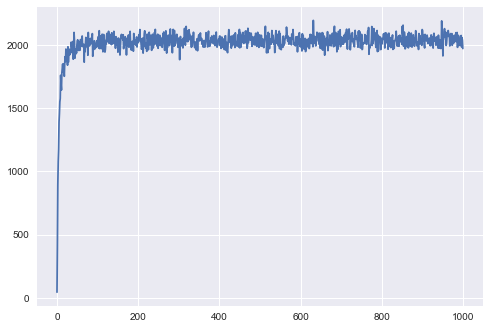

In [17]:
plt.plot(aR)
plt.show()